# USA Project Analysis: Manure and Food Waste 

In [3]:
#Load libraries
library(ggplot2)
library(tidyverse)
library(GGally)
library(VIM)
library(reshape2)
library(gridExtra)
library(missForest)
library(rpart)
library(randomForest)
library(caret)
library(ranger)
library(rpart.plot)
library(gbm)
library(MASS)
library(Benchmarking)

In [4]:
#Set global theme
theme_set(theme_minimal())

## 1. Data preparation, imputation, and vizualization

#### Data cleaning and imputation

In [5]:
# Read in data
df <- read.csv("DataUSA.csv", na.strings="")

In [6]:
# Change variable types (numeric or factor)
df$Cattle <- as.factor(df$Cattle)
df$Dairy <- as.factor(df$Dairy)
df$Poultry <- as.factor(df$Poultry)
df$Swine <- as.factor(df$Swine)
df$Codigestion <- as.factor(df$Codigestion)
df$CodigestionFW <- as.factor(df$CodigestionFW)


 Variables sorted by number of missings: 
             Variable     Count
     ElectricitykWhyr 0.2307692
          ProjectType 0.0000000
         DigesterType 0.0000000
               Cattle 0.0000000
                Dairy 0.0000000
              Poultry 0.0000000
                Swine 0.0000000
         CattleAmount 0.0000000
          DairyAmount 0.0000000
        PoultryAmount 0.0000000
          SwineAmount 0.0000000
          Codigestion 0.0000000
        CodigestionFW 0.0000000
 EmissionRedMetricTpy 0.0000000


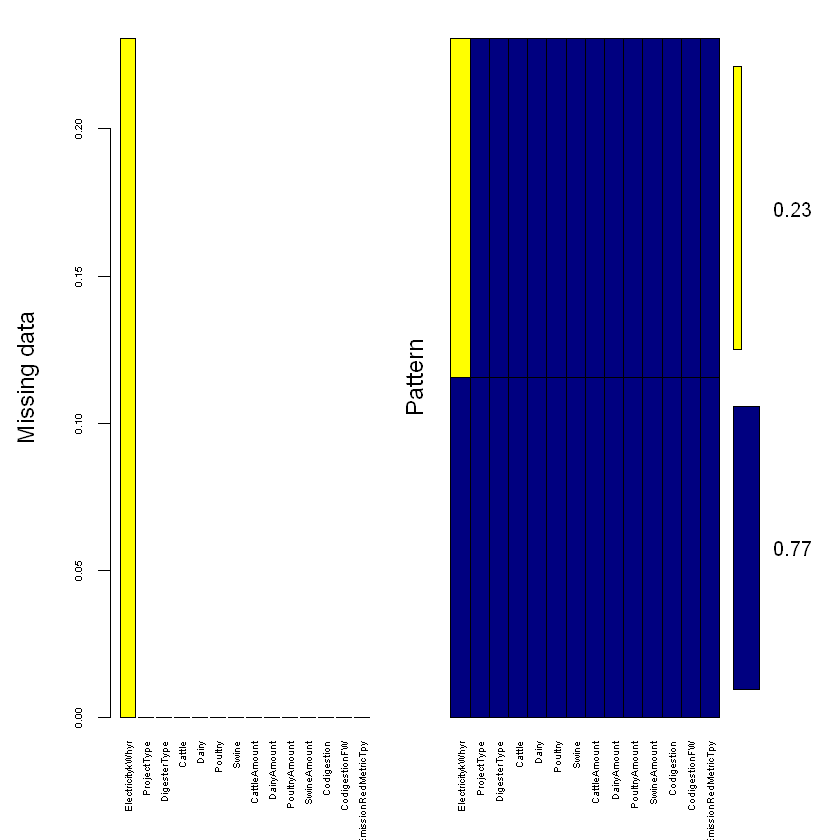

In [7]:
# Test for missing values and visualize  
missVals_plot <- aggr(df, col=c('navyblue','yellow'),
                    numbers=TRUE, sortVars=TRUE,
                    labels=names(df), cex.axis=.5,
                    gap=3, ylab=c("Missing data","Pattern"))

In [8]:
# Imputation of missing values with random forest
df_rfImp <- missForest(df)
df2 <- df_rfImp$ximp

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!


In [9]:
str(df2)

'data.frame':	273 obs. of  14 variables:
 $ ProjectType         : Factor w/ 4 levels "Centralized/Regional",..: 2 2 2 2 2 2 3 2 2 2 ...
 $ DigesterType        : Factor w/ 12 levels "Anaerobic Sequencing Batch Reactor",..: 3 3 3 3 3 3 3 2 3 3 ...
 $ Cattle              : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Dairy               : Factor w/ 2 levels "0","1": 1 2 2 2 2 2 2 2 2 2 ...
 $ Poultry             : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Swine               : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 1 1 1 1 ...
 $ CattleAmount        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ DairyAmount         : num  0 15000 4000 15500 1700 9700 7000 1700 7000 400 ...
 $ PoultryAmount       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ SwineAmount         : num  8400 0 0 0 0 0 0 0 0 0 ...
 $ Codigestion         : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 2 1 2 ...
 $ CodigestionFW       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ ElectricitykWhyr    : num  617344 5256000 

In [11]:
# # Visualize the distributions of our variables
# h2 <- ggplot(data = df2, aes(x = Codigestion)) + geom_bar()
# h3 <- ggplot(data = df2, aes(x = CodigestionFW)) + geom_bar()

# h4 <- ggplot(data = df2, aes(x = DairyAmount)) + geom_histogram(binwidth=2500)
# h5 <- ggplot(data = df2, aes(x = ElectricitykWhyr)) + geom_histogram(binwidth=5000000)
# h6 <- ggplot(data = df2, aes(x = EmissionRedMetricTpy)) + geom_histogram(binwidth=25000)

# # Place the plot objects into a grid
# grid.arrange(h1,h2,h3,h4,h5,h6,ncol=3)

In [12]:
# df2 <- filter(df2, DairyAmount > 0)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


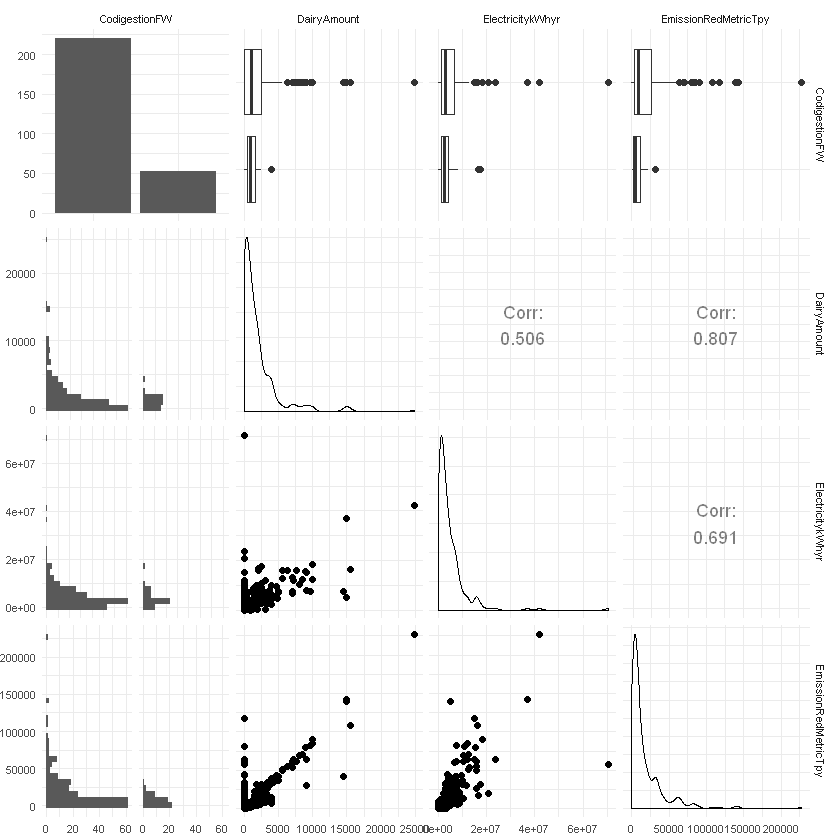

In [33]:
# Pairplot of selected variables:
ggpairs(df2[c("CodigestionFW","DairyAmount", "ElectricitykWhyr", "EmissionRedMetricTpy")]) + theme_minimal(base_size = 8)

## 2. Two-stage DEA

In [12]:
# Define input and output matrices
x <- with(df2, cbind(CattleAmount,DairyAmount,PoultryAmount,SwineAmount))
y <- with(df2, cbind(ElectricitykWhyr, EmissionRedMetricTpy))

In [13]:
# Compute DEA efficiency
e <- dea(x,y, ORIENTATION = "in")
summary(e)

Summary of efficiencies
The technology is vrs and input orientated efficiency
Number of firms with efficiency==1 are 14 
Mean efficiency: 0.248 
---                
  Eff range        #    %
  0<= E <0.1     144 52.7
  0.1<= E <0.2    19  7.0
  0.2<= E <0.3    17  6.2
  0.3<= E <0.4    14  5.1
  0.4<= E <0.5    20  7.3
  0.5<= E <0.6    12  4.4
  0.6<= E <0.7    10  3.7
  0.7<= E <0.8    13  4.8
  0.8<= E <0.9     7  2.6
  0.9<= E <1       3  1.1
        E ==1     14  5.1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.07289 0.24832 0.45560 1.00000 


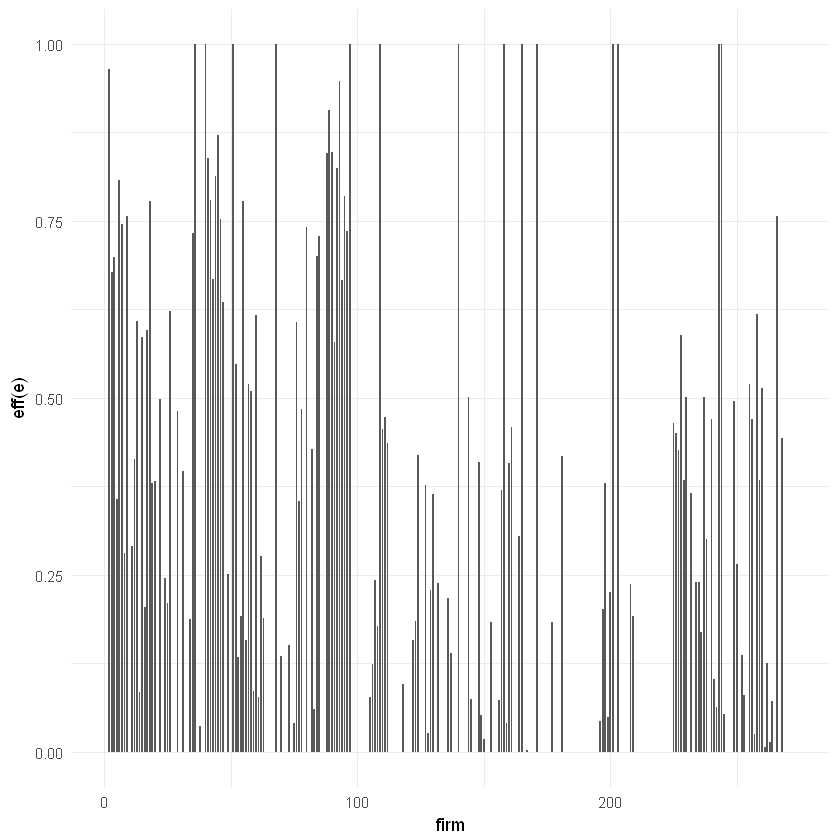

In [17]:
# Plot the efficiency scores 
test1 <- as.data.frame(eff(e))
test1$firm <- 1:273

ggplot(data=test1, aes(x=firm, y=eff(e))) +
    geom_bar(stat="identity", width=0.7)

In [18]:
# Input savings potential for each firm
(1-eff(e)) * x

CattleAmount,DairyAmount,PoultryAmount,SwineAmount
0,0.0000,0,8400
0,523.2413,0,0
0,1287.1619,0,0
0,4674.7118,0,0
0,1092.5565,0,0
0,1869.1278,0,0
0,1779.8684,0,0
0,1222.5179,0,0
0,1700.3936,0,0
0,400.0000,0,0


In [19]:
# calculate slacks
el <- dea(x,y,SLACK=TRUE)
data.frame(e$eff,el$eff,el$slack,el$sx,el$sy)

e.eff,el.eff,el.slack,sx1,sx2,sx3,sx4,sy1,sy2
0.00000000,0.00000000,TRUE,0,0,0,0,8142656,2552
0.96511725,0.96511725,TRUE,0,0,0,0,22309995,0
0.67820953,0.67820953,TRUE,0,0,0,0,6753655,0
0.69840569,0.69840569,TRUE,0,0,0,0,6286658,0
0.35731968,0.35731968,TRUE,0,0,0,0,4957787,0
0.80730641,0.80730641,TRUE,0,0,0,0,10732229,0
0.74573308,0.74573308,TRUE,0,0,0,0,8004878,0
0.28087185,0.28087185,TRUE,0,0,0,0,7246454,0
0.75708662,0.75708662,TRUE,0,0,0,0,7215300,0
0.00000000,0.00000000,TRUE,0,0,0,0,7394946,2943


In [20]:
# Fully efficient units, eff==1 and no slack
which(eff(e) == 1 & !el$slack)

[1]  36  40  51  68  97 109 140 158 165 171 201 203 243 244

In [24]:
# # Peer analysis
# np <- get.number.peers(e)
# np[which(np[,2]>10),]
# inp <- np[which(np[,2]>10),1]
# dea.plot(x[,2],y[,1], xlab="CattleAmount", ylab="ElectricitykWhyr")
# points(x[inp,2], y[inp,1], pch=16, col="red")
# title("Efficiency frontier")

## Second-stage DEA regression

In [25]:
# Append efficiency scores # Make the target variable efficiency in the 75th percentile
df2$efficiency <- e$eff
df2 <- df2 %>% mutate(Eff_High = case_when(efficiency >= 0.45560 ~ 1, efficiency < 0.45560 ~ 0))
df2$Eff_High <- as.factor(df2$Eff_High)

In [26]:
df3 <- NULL
df3 <- dplyr::select(df2, ProjectType, DigesterType, Codigestion, CodigestionFW, Eff_High)

In [27]:
# We will use repeated cross-validation
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           repeats = 10)

In [28]:
# We first train a gbm model
set.seed(0)
rf_mod <- train(Eff_High ~., data = df3, 
                 method = "gbm", 
                 trControl = fitControl,
                 tuneLength = 8)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1258             nan     0.1000    0.0005
     2        1.1187             nan     0.1000    0.0001
     3        1.1162             nan     0.1000   -0.0004
     4        1.1108             nan     0.1000    0.0011
     5        1.1059             nan     0.1000    0.0005
     6        1.1040             nan     0.1000   -0.0001
     7        1.0999             nan     0.1000    0.0021
     8        1.0970             nan     0.1000   -0.0015
     9        1.0922             nan     0.1000    0.0014
    10        1.0868             nan     0.1000    0.0018
    20        1.0560             nan     0.1000   -0.0004
    40        1.0303             nan     0.1000   -0.0012
    60        1.0208             nan     0.1000   -0.0003
    80        1.0151             nan     0.1000   -0.0015
   100        1.0109             nan     0.1000   -0.0024
   120        1.0070             nan     0.1000   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1203             nan     0.1000    0.0015
     2        1.1157             nan     0.1000    0.0019
     3        1.1118             nan     0.1000    0.0015
     4        1.1043             nan     0.1000    0.0016
     5        1.1004             nan     0.1000    0.0009
     6        1.0906             nan     0.1000    0.0030
     7        1.0857             nan     0.1000   -0.0002
     8        1.0830             nan     0.1000   -0.0003
     9        1.0777             nan     0.1000   -0.0038
    10        1.0707             nan     0.1000    0.0009
    20        1.0435             nan     0.1000   -0.0020
    40        1.0219             nan     0.1000   -0.0011
    60        1.0048             nan     0.1000    0.0005
    80        0.9980             nan     0.1000   -0.0006
   100        0.9950             nan     0.1000   -0.0042
   120        0.9925             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1109             nan     0.1000    0.0069
     2        1.1018             nan     0.1000    0.0044
     3        1.0900             nan     0.1000    0.0031
     4        1.0834             nan     0.1000    0.0006
     5        1.0756             nan     0.1000    0.0022
     6        1.0667             nan     0.1000    0.0044
     7        1.0551             nan     0.1000    0.0020
     8        1.0490             nan     0.1000    0.0005
     9        1.0416             nan     0.1000    0.0015
    10        1.0375             nan     0.1000   -0.0004
    20        1.0080             nan     0.1000   -0.0002
    40        0.9788             nan     0.1000   -0.0013
    60        0.9674             nan     0.1000   -0.0036
    80        0.9578             nan     0.1000   -0.0020
   100        0.9530             nan     0.1000   -0.0007
   120        0.9492             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1189             nan     0.1000    0.0033
     2        1.1006             nan     0.1000    0.0065
     3        1.0859             nan     0.1000    0.0050
     4        1.0748             nan     0.1000    0.0038
     5        1.0644             nan     0.1000    0.0041
     6        1.0558             nan     0.1000    0.0003
     7        1.0508             nan     0.1000   -0.0006
     8        1.0430             nan     0.1000   -0.0006
     9        1.0349             nan     0.1000   -0.0005
    10        1.0279             nan     0.1000    0.0022
    20        0.9946             nan     0.1000   -0.0023
    40        0.9599             nan     0.1000   -0.0009
    60        0.9498             nan     0.1000   -0.0022
    80        0.9404             nan     0.1000   -0.0035
   100        0.9365             nan     0.1000   -0.0017
   120        0.9272             nan     0.1000   -0.0029
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1070             nan     0.1000    0.0095
     2        1.0976             nan     0.1000    0.0031
     3        1.0809             nan     0.1000    0.0073
     4        1.0689             nan     0.1000    0.0036
     5        1.0505             nan     0.1000    0.0053
     6        1.0372             nan     0.1000    0.0004
     7        1.0305             nan     0.1000   -0.0029
     8        1.0238             nan     0.1000    0.0007
     9        1.0135             nan     0.1000   -0.0028
    10        1.0066             nan     0.1000    0.0018
    20        0.9805             nan     0.1000   -0.0066
    40        0.9530             nan     0.1000   -0.0005
    60        0.9512             nan     0.1000   -0.0035
    80        0.9365             nan     0.1000   -0.0008
   100        0.9289             nan     0.1000   -0.0044
   120        0.9240             nan     0.1000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1099             nan     0.1000    0.0052
     2        1.0873             nan     0.1000    0.0111
     3        1.0724             nan     0.1000    0.0060
     4        1.0583             nan     0.1000    0.0024
     5        1.0451             nan     0.1000    0.0052
     6        1.0379             nan     0.1000    0.0032
     7        1.0295             nan     0.1000    0.0048
     8        1.0210             nan     0.1000    0.0031
     9        1.0104             nan     0.1000    0.0031
    10        1.0045             nan     0.1000    0.0009
    20        0.9707             nan     0.1000    0.0001
    40        0.9461             nan     0.1000   -0.0024
    60        0.9352             nan     0.1000   -0.0043
    80        0.9245             nan     0.1000   -0.0041
   100        0.9207             nan     0.1000   -0.0029
   120        0.9164             nan     0.1000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1030             nan     0.1000    0.0087
     2        1.0869             nan     0.1000    0.0064
     3        1.0720             nan     0.1000    0.0056
     4        1.0601             nan     0.1000    0.0012
     5        1.0467             nan     0.1000    0.0046
     6        1.0355             nan     0.1000    0.0044
     7        1.0237             nan     0.1000    0.0014
     8        1.0175             nan     0.1000   -0.0019
     9        1.0107             nan     0.1000   -0.0006
    10        1.0048             nan     0.1000    0.0009
    20        0.9683             nan     0.1000   -0.0033
    40        0.9447             nan     0.1000    0.0005
    60        0.9321             nan     0.1000   -0.0025
    80        0.9233             nan     0.1000   -0.0024
   100        0.9150             nan     0.1000   -0.0039
   120        0.9098             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1071             nan     0.1000    0.0086
     2        1.0894             nan     0.1000    0.0086
     3        1.0711             nan     0.1000    0.0055
     4        1.0549             nan     0.1000    0.0041
     5        1.0396             nan     0.1000    0.0040
     6        1.0279             nan     0.1000    0.0026
     7        1.0179             nan     0.1000    0.0054
     8        1.0088             nan     0.1000    0.0022
     9        1.0036             nan     0.1000    0.0002
    10        0.9975             nan     0.1000   -0.0003
    20        0.9565             nan     0.1000   -0.0010
    40        0.9327             nan     0.1000   -0.0017
    60        0.9228             nan     0.1000   -0.0023
    80        0.9135             nan     0.1000   -0.0041
   100        0.9052             nan     0.1000   -0.0035
   120        0.9038             nan     0.1000   -0.0043
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1048             nan     0.1000    0.0094
     2        1.0802             nan     0.1000    0.0076
     3        1.0679             nan     0.1000    0.0068
     4        1.0526             nan     0.1000    0.0066
     5        1.0391             nan     0.1000    0.0049
     6        1.0293             nan     0.1000    0.0014
     7        1.0213             nan     0.1000    0.0004
     8        1.0159             nan     0.1000   -0.0001
     9        1.0065             nan     0.1000    0.0025
    10        1.0017             nan     0.1000   -0.0027
    20        0.9631             nan     0.1000    0.0005
    40        0.9462             nan     0.1000   -0.0039
    60        0.9264             nan     0.1000   -0.0059
    80        0.9186             nan     0.1000   -0.0047
   100        0.9146             nan     0.1000   -0.0038
   120        0.9074             nan     0.1000   -0.0043
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1225             nan     0.1000    0.0050
     2        1.1140             nan     0.1000    0.0023
     3        1.1065             nan     0.1000    0.0029
     4        1.0984             nan     0.1000    0.0008
     5        1.0946             nan     0.1000   -0.0002
     6        1.0904             nan     0.1000    0.0012
     7        1.0859             nan     0.1000    0.0004
     8        1.0831             nan     0.1000   -0.0015
     9        1.0817             nan     0.1000   -0.0006
    10        1.0771             nan     0.1000    0.0019
    20        1.0435             nan     0.1000   -0.0027
    40        1.0157             nan     0.1000   -0.0005
    60        1.0048             nan     0.1000   -0.0010
    80        0.9986             nan     0.1000   -0.0010
   100        0.9952             nan     0.1000   -0.0021
   120        0.9950             nan     0.1000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1145             nan     0.1000    0.0078
     2        1.1063             nan     0.1000    0.0045
     3        1.0944             nan     0.1000    0.0038
     4        1.0884             nan     0.1000   -0.0013
     5        1.0771             nan     0.1000    0.0015
     6        1.0701             nan     0.1000    0.0002
     7        1.0639             nan     0.1000    0.0033
     8        1.0575             nan     0.1000    0.0025
     9        1.0527             nan     0.1000   -0.0032
    10        1.0488             nan     0.1000   -0.0029
    20        1.0174             nan     0.1000   -0.0077
    40        0.9950             nan     0.1000    0.0007
    60        0.9856             nan     0.1000   -0.0043
    80        0.9761             nan     0.1000   -0.0006
   100        0.9727             nan     0.1000   -0.0012
   120        0.9667             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1120             nan     0.1000    0.0074
     2        1.0944             nan     0.1000    0.0051
     3        1.0818             nan     0.1000    0.0040
     4        1.0766             nan     0.1000   -0.0017
     5        1.0668             nan     0.1000    0.0014
     6        1.0575             nan     0.1000    0.0035
     7        1.0511             nan     0.1000   -0.0034
     8        1.0439             nan     0.1000    0.0005
     9        1.0406             nan     0.1000   -0.0006
    10        1.0360             nan     0.1000    0.0000
    20        1.0000             nan     0.1000    0.0001
    40        0.9743             nan     0.1000   -0.0049
    60        0.9674             nan     0.1000   -0.0038
    80        0.9614             nan     0.1000   -0.0029
   100        0.9537             nan     0.1000   -0.0011
   120        0.9498             nan     0.1000   -0.0047
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1132             nan     0.1000    0.0037
     2        1.0960             nan     0.1000    0.0077
     3        1.0861             nan     0.1000    0.0020
     4        1.0778             nan     0.1000    0.0007
     5        1.0708             nan     0.1000    0.0023
     6        1.0653             nan     0.1000    0.0016
     7        1.0519             nan     0.1000    0.0051
     8        1.0440             nan     0.1000    0.0039
     9        1.0397             nan     0.1000    0.0011
    10        1.0312             nan     0.1000    0.0017
    20        0.9909             nan     0.1000   -0.0016
    40        0.9655             nan     0.1000   -0.0019
    60        0.9531             nan     0.1000   -0.0045
    80        0.9504             nan     0.1000   -0.0030
   100        0.9442             nan     0.1000   -0.0038
   120        0.9378             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1051             nan     0.1000    0.0110
     2        1.0931             nan     0.1000    0.0067
     3        1.0760             nan     0.1000    0.0038
     4        1.0677             nan     0.1000    0.0035
     5        1.0523             nan     0.1000   -0.0003
     6        1.0450             nan     0.1000    0.0010
     7        1.0384             nan     0.1000   -0.0001
     8        1.0317             nan     0.1000    0.0003
     9        1.0257             nan     0.1000   -0.0019
    10        1.0194             nan     0.1000   -0.0015
    20        0.9896             nan     0.1000    0.0006
    40        0.9644             nan     0.1000   -0.0045
    60        0.9513             nan     0.1000   -0.0010
    80        0.9439             nan     0.1000   -0.0034
   100        0.9403             nan     0.1000   -0.0034
   120        0.9291             nan     0.1000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1072             nan     0.1000    0.0095
     2        1.0851             nan     0.1000    0.0046
     3        1.0746             nan     0.1000    0.0058
     4        1.0612             nan     0.1000    0.0044
     5        1.0493             nan     0.1000    0.0027
     6        1.0425             nan     0.1000    0.0018
     7        1.0361             nan     0.1000    0.0006
     8        1.0298             nan     0.1000    0.0004
     9        1.0237             nan     0.1000    0.0001
    10        1.0187             nan     0.1000   -0.0007
    20        0.9778             nan     0.1000   -0.0040
    40        0.9596             nan     0.1000   -0.0013
    60        0.9518             nan     0.1000   -0.0024
    80        0.9405             nan     0.1000   -0.0014
   100        0.9335             nan     0.1000   -0.0037
   120        0.9289             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1122             nan     0.1000    0.0088
     2        1.0960             nan     0.1000    0.0030
     3        1.0788             nan     0.1000   -0.0029
     4        1.0676             nan     0.1000    0.0040
     5        1.0559             nan     0.1000    0.0031
     6        1.0465             nan     0.1000    0.0015
     7        1.0341             nan     0.1000    0.0042
     8        1.0275             nan     0.1000    0.0014
     9        1.0226             nan     0.1000    0.0025
    10        1.0142             nan     0.1000   -0.0022
    20        0.9744             nan     0.1000    0.0005
    40        0.9532             nan     0.1000   -0.0014
    60        0.9498             nan     0.1000   -0.0043
    80        0.9339             nan     0.1000   -0.0025
   100        0.9293             nan     0.1000   -0.0023
   120        0.9262             nan     0.1000   -0.0042
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1068             nan     0.1000    0.0102
     2        1.0902             nan     0.1000    0.0040
     3        1.0769             nan     0.1000    0.0046
     4        1.0648             nan     0.1000    0.0031
     5        1.0527             nan     0.1000    0.0044
     6        1.0438             nan     0.1000    0.0039
     7        1.0341             nan     0.1000    0.0039
     8        1.0286             nan     0.1000    0.0019
     9        1.0203             nan     0.1000    0.0003
    10        1.0108             nan     0.1000    0.0024
    20        0.9763             nan     0.1000   -0.0019
    40        0.9525             nan     0.1000   -0.0010
    60        0.9421             nan     0.1000   -0.0032
    80        0.9314             nan     0.1000   -0.0007
   100        0.9256             nan     0.1000   -0.0018
   120        0.9209             nan     0.1000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1218             nan     0.1000    0.0029
     2        1.1150             nan     0.1000    0.0031
     3        1.1091             nan     0.1000    0.0014
     4        1.1071             nan     0.1000   -0.0007
     5        1.1000             nan     0.1000    0.0011
     6        1.0952             nan     0.1000    0.0011
     7        1.0901             nan     0.1000    0.0006
     8        1.0885             nan     0.1000   -0.0017
     9        1.0809             nan     0.1000    0.0011
    10        1.0774             nan     0.1000    0.0014
    20        1.0426             nan     0.1000    0.0007
    40        1.0117             nan     0.1000   -0.0019
    60        1.0020             nan     0.1000   -0.0024
    80        0.9966             nan     0.1000   -0.0019
   100        0.9933             nan     0.1000   -0.0041
   120        0.9898             nan     0.1000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1138             nan     0.1000    0.0065
     2        1.0990             nan     0.1000    0.0056
     3        1.0865             nan     0.1000    0.0038
     4        1.0784             nan     0.1000    0.0003
     5        1.0691             nan     0.1000    0.0011
     6        1.0632             nan     0.1000    0.0006
     7        1.0556             nan     0.1000    0.0024
     8        1.0510             nan     0.1000    0.0012
     9        1.0438             nan     0.1000    0.0025
    10        1.0404             nan     0.1000   -0.0019
    20        1.0087             nan     0.1000   -0.0004
    40        0.9783             nan     0.1000   -0.0014
    60        0.9672             nan     0.1000   -0.0037
    80        0.9600             nan     0.1000   -0.0007
   100        0.9549             nan     0.1000   -0.0022
   120        0.9512             nan     0.1000   -0.0033
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1149             nan     0.1000    0.0090
     2        1.0988             nan     0.1000    0.0064
     3        1.0872             nan     0.1000    0.0033
     4        1.0778             nan     0.1000    0.0035
     5        1.0675             nan     0.1000   -0.0025
     6        1.0602             nan     0.1000    0.0014
     7        1.0531             nan     0.1000    0.0005
     8        1.0406             nan     0.1000    0.0003
     9        1.0376             nan     0.1000   -0.0029
    10        1.0295             nan     0.1000    0.0011
    20        0.9894             nan     0.1000   -0.0029
    40        0.9611             nan     0.1000   -0.0025
    60        0.9526             nan     0.1000   -0.0036
    80        0.9485             nan     0.1000   -0.0053
   100        0.9412             nan     0.1000   -0.0009
   120        0.9349             nan     0.1000   -0.0032
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1129             nan     0.1000    0.0064
     2        1.0956             nan     0.1000    0.0073
     3        1.0822             nan     0.1000    0.0057
     4        1.0686             nan     0.1000   -0.0009
     5        1.0569             nan     0.1000    0.0051
     6        1.0468             nan     0.1000    0.0002
     7        1.0399             nan     0.1000   -0.0002
     8        1.0335             nan     0.1000    0.0034
     9        1.0253             nan     0.1000    0.0006
    10        1.0177             nan     0.1000    0.0016
    20        0.9782             nan     0.1000    0.0001
    40        0.9558             nan     0.1000   -0.0031
    60        0.9381             nan     0.1000    0.0005
    80        0.9319             nan     0.1000   -0.0039
   100        0.9242             nan     0.1000   -0.0021
   120        0.9194             nan     0.1000   -0.0037
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1118             nan     0.1000    0.0090
     2        1.0913             nan     0.1000    0.0068
     3        1.0748             nan     0.1000    0.0053
     4        1.0636             nan     0.1000    0.0045
     5        1.0484             nan     0.1000    0.0033
     6        1.0406             nan     0.1000    0.0011
     7        1.0357             nan     0.1000   -0.0036
     8        1.0238             nan     0.1000   -0.0008
     9        1.0137             nan     0.1000    0.0025
    10        1.0070             nan     0.1000   -0.0006
    20        0.9654             nan     0.1000   -0.0006
    40        0.9438             nan     0.1000   -0.0027
    60        0.9225             nan     0.1000   -0.0023
    80        0.9105             nan     0.1000   -0.0093
   100        0.9066             nan     0.1000   -0.0030
   120        0.8982             nan     0.1000   -0.0041
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1042             nan     0.1000    0.0094
     2        1.0829             nan     0.1000    0.0052
     3        1.0691             nan     0.1000    0.0052
     4        1.0522             nan     0.1000    0.0027
     5        1.0422             nan     0.1000    0.0032
     6        1.0348             nan     0.1000    0.0018
     7        1.0279             nan     0.1000    0.0000
     8        1.0179             nan     0.1000   -0.0012
     9        1.0128             nan     0.1000   -0.0010
    10        1.0068             nan     0.1000   -0.0019
    20        0.9673             nan     0.1000   -0.0039
    40        0.9388             nan     0.1000   -0.0040
    60        0.9243             nan     0.1000   -0.0041
    80        0.9128             nan     0.1000   -0.0000
   100        0.9020             nan     0.1000   -0.0021
   120        0.8951             nan     0.1000   -0.0042
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1152             nan     0.1000    0.0096
     2        1.0952             nan     0.1000    0.0080
     3        1.0751             nan     0.1000    0.0054
     4        1.0602             nan     0.1000    0.0029
     5        1.0476             nan     0.1000    0.0038
     6        1.0399             nan     0.1000   -0.0008
     7        1.0353             nan     0.1000    0.0021
     8        1.0266             nan     0.1000    0.0005
     9        1.0206             nan     0.1000    0.0002
    10        1.0149             nan     0.1000   -0.0017
    20        0.9752             nan     0.1000   -0.0030
    40        0.9488             nan     0.1000   -0.0036
    60        0.9292             nan     0.1000   -0.0022
    80        0.9182             nan     0.1000   -0.0028
   100        0.9106             nan     0.1000   -0.0017
   120        0.9045             nan     0.1000   -0.0028
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1089             nan     0.1000    0.0112
     2        1.0932             nan     0.1000    0.0081
     3        1.0837             nan     0.1000    0.0009
     4        1.0623             nan     0.1000    0.0027
     5        1.0512             nan     0.1000    0.0042
     6        1.0452             nan     0.1000    0.0012
     7        1.0356             nan     0.1000    0.0038
     8        1.0295             nan     0.1000    0.0021
     9        1.0189             nan     0.1000   -0.0003
    10        1.0149             nan     0.1000    0.0010
    20        0.9664             nan     0.1000   -0.0014
    40        0.9393             nan     0.1000   -0.0033
    60        0.9235             nan     0.1000   -0.0036
    80        0.9144             nan     0.1000   -0.0032
   100        0.9044             nan     0.1000   -0.0029
   120        0.8960             nan     0.1000   -0.0041
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1265             nan     0.1000   -0.0027
     2        1.1157             nan     0.1000    0.0042
     3        1.1110             nan     0.1000    0.0003
     4        1.1045             nan     0.1000    0.0024
     5        1.0981             nan     0.1000    0.0028
     6        1.0947             nan     0.1000   -0.0017
     7        1.0904             nan     0.1000   -0.0011
     8        1.0888             nan     0.1000   -0.0010
     9        1.0842             nan     0.1000    0.0020
    10        1.0788             nan     0.1000    0.0005
    20        1.0520             nan     0.1000    0.0005
    40        1.0232             nan     0.1000   -0.0009
    60        1.0109             nan     0.1000    0.0002
    80        1.0068             nan     0.1000   -0.0007
   100        1.0029             nan     0.1000   -0.0007
   120        0.9998             nan     0.1000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1189             nan     0.1000    0.0052
     2        1.1102             nan     0.1000    0.0048
     3        1.0973             nan     0.1000    0.0042
     4        1.0861             nan     0.1000    0.0022
     5        1.0798             nan     0.1000    0.0012
     6        1.0728             nan     0.1000    0.0004
     7        1.0645             nan     0.1000    0.0034
     8        1.0579             nan     0.1000    0.0017
     9        1.0547             nan     0.1000    0.0008
    10        1.0490             nan     0.1000   -0.0042
    20        1.0208             nan     0.1000   -0.0014
    40        0.9931             nan     0.1000   -0.0033
    60        0.9779             nan     0.1000   -0.0013
    80        0.9703             nan     0.1000   -0.0019
   100        0.9638             nan     0.1000   -0.0022
   120        0.9606             nan     0.1000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1118             nan     0.1000    0.0046
     2        1.0999             nan     0.1000    0.0056
     3        1.0846             nan     0.1000    0.0002
     4        1.0774             nan     0.1000    0.0033
     5        1.0652             nan     0.1000    0.0025
     6        1.0615             nan     0.1000   -0.0041
     7        1.0524             nan     0.1000   -0.0017
     8        1.0460             nan     0.1000   -0.0010
     9        1.0391             nan     0.1000    0.0034
    10        1.0315             nan     0.1000    0.0041
    20        0.9978             nan     0.1000   -0.0002
    40        0.9735             nan     0.1000   -0.0013
    60        0.9668             nan     0.1000   -0.0022
    80        0.9505             nan     0.1000   -0.0031
   100        0.9451             nan     0.1000   -0.0026
   120        0.9397             nan     0.1000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1085             nan     0.1000    0.0044
     2        1.1017             nan     0.1000   -0.0004
     3        1.0828             nan     0.1000    0.0043
     4        1.0671             nan     0.1000    0.0043
     5        1.0583             nan     0.1000    0.0028
     6        1.0478             nan     0.1000    0.0032
     7        1.0378             nan     0.1000    0.0027
     8        1.0313             nan     0.1000    0.0002
     9        1.0276             nan     0.1000   -0.0007
    10        1.0241             nan     0.1000    0.0001
    20        0.9910             nan     0.1000   -0.0005
    40        0.9661             nan     0.1000   -0.0027
    60        0.9538             nan     0.1000   -0.0014
    80        0.9439             nan     0.1000   -0.0010
   100        0.9378             nan     0.1000   -0.0022
   120        0.9308             nan     0.1000   -0.0042
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1052             nan     0.1000    0.0083
     2        1.0880             nan     0.1000    0.0053
     3        1.0720             nan     0.1000    0.0042
     4        1.0553             nan     0.1000    0.0060
     5        1.0448             nan     0.1000    0.0035
     6        1.0378             nan     0.1000    0.0005
     7        1.0311             nan     0.1000    0.0009
     8        1.0274             nan     0.1000   -0.0036
     9        1.0241             nan     0.1000   -0.0023
    10        1.0175             nan     0.1000   -0.0010
    20        0.9744             nan     0.1000   -0.0011
    40        0.9546             nan     0.1000   -0.0041
    60        0.9403             nan     0.1000   -0.0012
    80        0.9317             nan     0.1000   -0.0027
   100        0.9266             nan     0.1000   -0.0017
   120        0.9186             nan     0.1000   -0.0022
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1079             nan     0.1000    0.0069
     2        1.0858             nan     0.1000    0.0037
     3        1.0710             nan     0.1000    0.0064
     4        1.0573             nan     0.1000    0.0053
     5        1.0495             nan     0.1000    0.0011
     6        1.0438             nan     0.1000    0.0008
     7        1.0377             nan     0.1000   -0.0012
     8        1.0289             nan     0.1000    0.0019
     9        1.0199             nan     0.1000    0.0026
    10        1.0132             nan     0.1000    0.0029
    20        0.9787             nan     0.1000   -0.0015
    40        0.9553             nan     0.1000   -0.0033
    60        0.9438             nan     0.1000   -0.0052
    80        0.9340             nan     0.1000   -0.0012
   100        0.9278             nan     0.1000   -0.0026
   120        0.9213             nan     0.1000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1081             nan     0.1000    0.0084
     2        1.0872             nan     0.1000    0.0067
     3        1.0689             nan     0.1000    0.0057
     4        1.0593             nan     0.1000    0.0024
     5        1.0494             nan     0.1000    0.0032
     6        1.0419             nan     0.1000    0.0017
     7        1.0328             nan     0.1000    0.0016
     8        1.0234             nan     0.1000    0.0003
     9        1.0140             nan     0.1000    0.0004
    10        1.0104             nan     0.1000   -0.0013
    20        0.9683             nan     0.1000   -0.0076
    40        0.9551             nan     0.1000   -0.0048
    60        0.9346             nan     0.1000   -0.0018
    80        0.9224             nan     0.1000   -0.0027
   100        0.9163             nan     0.1000   -0.0022
   120        0.9095             nan     0.1000   -0.0036
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1099             nan     0.1000    0.0086
     2        1.0884             nan     0.1000    0.0079
     3        1.0722             nan     0.1000    0.0032
     4        1.0622             nan     0.1000    0.0038
     5        1.0543             nan     0.1000    0.0028
     6        1.0453             nan     0.1000    0.0011
     7        1.0353             nan     0.1000    0.0039
     8        1.0249             nan     0.1000   -0.0017
     9        1.0179             nan     0.1000    0.0011
    10        1.0114             nan     0.1000    0.0015
    20        0.9806             nan     0.1000   -0.0049
    40        0.9616             nan     0.1000   -0.0017
    60        0.9476             nan     0.1000   -0.0026
    80        0.9345             nan     0.1000   -0.0020
   100        0.9224             nan     0.1000   -0.0024
   120        0.9156             nan     0.1000   -0.0035
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1155             nan     0.1000    0.0040
     2        1.1081             nan     0.1000    0.0027
     3        1.1014             nan     0.1000    0.0013
     4        1.0952             nan     0.1000    0.0017
     5        1.0852             nan     0.1000    0.0033
     6        1.0792             nan     0.1000    0.0007
     7        1.0747             nan     0.1000    0.0002
     8        1.0711             nan     0.1000    0.0009
     9        1.0660             nan     0.1000    0.0008
    10        1.0612             nan     0.1000    0.0023
    20        1.0268             nan     0.1000    0.0011
    40        0.9986             nan     0.1000   -0.0046
    60        0.9884             nan     0.1000   -0.0004
    80        0.9792             nan     0.1000   -0.0019
   100        0.9755             nan     0.1000   -0.0033
   120        0.9740             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1129             nan     0.1000    0.0065
     2        1.0962             nan     0.1000    0.0046
     3        1.0812             nan     0.1000    0.0056
     4        1.0733             nan     0.1000    0.0026
     5        1.0605             nan     0.1000    0.0019
     6        1.0520             nan     0.1000    0.0008
     7        1.0484             nan     0.1000   -0.0009
     8        1.0446             nan     0.1000   -0.0021
     9        1.0423             nan     0.1000    0.0008
    10        1.0382             nan     0.1000   -0.0027
    20        1.0048             nan     0.1000   -0.0027
    40        0.9686             nan     0.1000   -0.0024
    60        0.9543             nan     0.1000   -0.0028
    80        0.9472             nan     0.1000   -0.0001
   100        0.9476             nan     0.1000   -0.0022
   120        0.9430             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1128             nan     0.1000    0.0089
     2        1.0994             nan     0.1000    0.0074
     3        1.0784             nan     0.1000    0.0067
     4        1.0705             nan     0.1000    0.0022
     5        1.0572             nan     0.1000    0.0032
     6        1.0486             nan     0.1000    0.0024
     7        1.0401             nan     0.1000    0.0018
     8        1.0307             nan     0.1000    0.0002
     9        1.0222             nan     0.1000    0.0018
    10        1.0160             nan     0.1000    0.0023
    20        0.9766             nan     0.1000    0.0002
    40        0.9507             nan     0.1000   -0.0036
    60        0.9394             nan     0.1000   -0.0019
    80        0.9327             nan     0.1000   -0.0007
   100        0.9311             nan     0.1000   -0.0045
   120        0.9201             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1097             nan     0.1000    0.0104
     2        1.0893             nan     0.1000    0.0097
     3        1.0740             nan     0.1000    0.0077
     4        1.0590             nan     0.1000    0.0062
     5        1.0511             nan     0.1000    0.0022
     6        1.0424             nan     0.1000   -0.0003
     7        1.0324             nan     0.1000    0.0035
     8        1.0246             nan     0.1000   -0.0003
     9        1.0154             nan     0.1000    0.0017
    10        1.0109             nan     0.1000   -0.0021
    20        0.9629             nan     0.1000   -0.0034
    40        0.9439             nan     0.1000   -0.0014
    60        0.9348             nan     0.1000   -0.0027
    80        0.9288             nan     0.1000   -0.0037
   100        0.9227             nan     0.1000   -0.0022
   120        0.9189             nan     0.1000   -0.0052
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1011             nan     0.1000    0.0108
     2        1.0820             nan     0.1000    0.0097
     3        1.0624             nan     0.1000    0.0081
     4        1.0479             nan     0.1000    0.0062
     5        1.0356             nan     0.1000    0.0050
     6        1.0235             nan     0.1000    0.0032
     7        1.0119             nan     0.1000    0.0004
     8        0.9997             nan     0.1000    0.0023
     9        0.9934             nan     0.1000    0.0016
    10        0.9898             nan     0.1000   -0.0008
    20        0.9570             nan     0.1000   -0.0003
    40        0.9326             nan     0.1000   -0.0013
    60        0.9210             nan     0.1000   -0.0008
    80        0.9133             nan     0.1000   -0.0026
   100        0.9066             nan     0.1000   -0.0015
   120        0.9060             nan     0.1000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1046             nan     0.1000    0.0108
     2        1.0841             nan     0.1000    0.0075
     3        1.0648             nan     0.1000    0.0068
     4        1.0516             nan     0.1000    0.0031
     5        1.0378             nan     0.1000    0.0039
     6        1.0248             nan     0.1000   -0.0015
     7        1.0170             nan     0.1000    0.0017
     8        1.0085             nan     0.1000    0.0023
     9        1.0039             nan     0.1000   -0.0016
    10        0.9949             nan     0.1000    0.0042
    20        0.9538             nan     0.1000   -0.0028
    40        0.9246             nan     0.1000   -0.0054
    60        0.9091             nan     0.1000   -0.0020
    80        0.9013             nan     0.1000    0.0000
   100        0.8932             nan     0.1000   -0.0011
   120        0.8882             nan     0.1000   -0.0047
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1112             nan     0.1000    0.0089
     2        1.0824             nan     0.1000    0.0075
     3        1.0670             nan     0.1000    0.0059
     4        1.0498             nan     0.1000    0.0048
     5        1.0333             nan     0.1000    0.0058
     6        1.0204             nan     0.1000    0.0043
     7        1.0102             nan     0.1000    0.0018
     8        1.0006             nan     0.1000    0.0009
     9        0.9929             nan     0.1000    0.0013
    10        0.9847             nan     0.1000   -0.0009
    20        0.9564             nan     0.1000   -0.0054
    40        0.9256             nan     0.1000   -0.0058
    60        0.9147             nan     0.1000   -0.0015
    80        0.9066             nan     0.1000   -0.0011
   100        0.9001             nan     0.1000   -0.0031
   120        0.8925             nan     0.1000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1089             nan     0.1000    0.0106
     2        1.0875             nan     0.1000    0.0088
     3        1.0676             nan     0.1000    0.0066
     4        1.0501             nan     0.1000    0.0059
     5        1.0393             nan     0.1000    0.0042
     6        1.0266             nan     0.1000    0.0032
     7        1.0197             nan     0.1000    0.0008
     8        1.0098             nan     0.1000   -0.0004
     9        1.0039             nan     0.1000   -0.0004
    10        0.9971             nan     0.1000   -0.0003
    20        0.9544             nan     0.1000   -0.0007
    40        0.9300             nan     0.1000   -0.0027
    60        0.9186             nan     0.1000   -0.0037
    80        0.9134             nan     0.1000   -0.0150
   100        0.9013             nan     0.1000   -0.0020
   120        0.8980             nan     0.1000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1276             nan     0.1000   -0.0005
     2        1.1154             nan     0.1000    0.0059
     3        1.1100             nan     0.1000    0.0002
     4        1.0991             nan     0.1000    0.0029
     5        1.0961             nan     0.1000   -0.0008
     6        1.0873             nan     0.1000    0.0021
     7        1.0807             nan     0.1000    0.0019
     8        1.0754             nan     0.1000   -0.0002
     9        1.0680             nan     0.1000    0.0005
    10        1.0649             nan     0.1000    0.0000
    20        1.0367             nan     0.1000    0.0001
    40        1.0038             nan     0.1000   -0.0004
    60        0.9934             nan     0.1000   -0.0017
    80        0.9889             nan     0.1000   -0.0018
   100        0.9867             nan     0.1000   -0.0022
   120        0.9841             nan     0.1000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1095             nan     0.1000    0.0071
     2        1.0950             nan     0.1000    0.0033
     3        1.0855             nan     0.1000    0.0047
     4        1.0728             nan     0.1000    0.0038
     5        1.0635             nan     0.1000   -0.0002
     6        1.0544             nan     0.1000    0.0028
     7        1.0490             nan     0.1000   -0.0003
     8        1.0442             nan     0.1000   -0.0007
     9        1.0376             nan     0.1000    0.0016
    10        1.0340             nan     0.1000   -0.0010
    20        0.9985             nan     0.1000   -0.0003
    40        0.9750             nan     0.1000   -0.0021
    60        0.9593             nan     0.1000   -0.0015
    80        0.9512             nan     0.1000   -0.0008
   100        0.9429             nan     0.1000   -0.0006
   120        0.9399             nan     0.1000   -0.0039
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1096             nan     0.1000    0.0075
     2        1.0916             nan     0.1000    0.0080
     3        1.0724             nan     0.1000    0.0034
     4        1.0591             nan     0.1000    0.0036
     5        1.0494             nan     0.1000    0.0027
     6        1.0408             nan     0.1000    0.0012
     7        1.0315             nan     0.1000    0.0020
     8        1.0231             nan     0.1000   -0.0018
     9        1.0162             nan     0.1000    0.0017
    10        1.0129             nan     0.1000    0.0009
    20        0.9789             nan     0.1000   -0.0041
    40        0.9523             nan     0.1000   -0.0009
    60        0.9425             nan     0.1000   -0.0024
    80        0.9340             nan     0.1000   -0.0019
   100        0.9288             nan     0.1000   -0.0039
   120        0.9278             nan     0.1000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1075             nan     0.1000    0.0060
     2        1.0893             nan     0.1000    0.0076
     3        1.0666             nan     0.1000    0.0033
     4        1.0558             nan     0.1000    0.0053
     5        1.0432             nan     0.1000    0.0049
     6        1.0354             nan     0.1000    0.0021
     7        1.0310             nan     0.1000    0.0016
     8        1.0224             nan     0.1000    0.0007
     9        1.0155             nan     0.1000    0.0006
    10        1.0114             nan     0.1000    0.0001
    20        0.9736             nan     0.1000   -0.0021
    40        0.9472             nan     0.1000   -0.0033
    60        0.9292             nan     0.1000   -0.0029
    80        0.9208             nan     0.1000   -0.0033
   100        0.9147             nan     0.1000   -0.0026
   120        0.9104             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1054             nan     0.1000    0.0016
     2        1.0874             nan     0.1000    0.0083
     3        1.0766             nan     0.1000    0.0024
     4        1.0614             nan     0.1000    0.0053
     5        1.0508             nan     0.1000    0.0030
     6        1.0397             nan     0.1000    0.0004
     7        1.0282             nan     0.1000    0.0059
     8        1.0191             nan     0.1000    0.0019
     9        1.0100             nan     0.1000    0.0012
    10        0.9996             nan     0.1000    0.0033
    20        0.9643             nan     0.1000    0.0002
    40        0.9466             nan     0.1000   -0.0003
    60        0.9331             nan     0.1000   -0.0017
    80        0.9236             nan     0.1000   -0.0079
   100        0.9136             nan     0.1000   -0.0035
   120        0.9089             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1052             nan     0.1000    0.0108
     2        1.0817             nan     0.1000    0.0078
     3        1.0639             nan     0.1000    0.0010
     4        1.0497             nan     0.1000    0.0028
     5        1.0388             nan     0.1000    0.0044
     6        1.0257             nan     0.1000    0.0047
     7        1.0143             nan     0.1000    0.0007
     8        1.0073             nan     0.1000    0.0007
     9        1.0041             nan     0.1000   -0.0016
    10        1.0015             nan     0.1000   -0.0029
    20        0.9669             nan     0.1000   -0.0005
    40        0.9337             nan     0.1000   -0.0029
    60        0.9194             nan     0.1000   -0.0024
    80        0.9096             nan     0.1000   -0.0019
   100        0.9003             nan     0.1000   -0.0022
   120        0.8968             nan     0.1000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1097             nan     0.1000    0.0044
     2        1.0868             nan     0.1000    0.0068
     3        1.0718             nan     0.1000    0.0048
     4        1.0642             nan     0.1000    0.0025
     5        1.0538             nan     0.1000    0.0037
     6        1.0370             nan     0.1000    0.0053
     7        1.0302             nan     0.1000    0.0026
     8        1.0217             nan     0.1000    0.0024
     9        1.0079             nan     0.1000    0.0014
    10        0.9988             nan     0.1000    0.0033
    20        0.9625             nan     0.1000   -0.0023
    40        0.9366             nan     0.1000   -0.0024
    60        0.9250             nan     0.1000   -0.0032
    80        0.9129             nan     0.1000   -0.0027
   100        0.9084             nan     0.1000   -0.0001
   120        0.9004             nan     0.1000   -0.0079
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1025             nan     0.1000    0.0080
     2        1.0809             nan     0.1000    0.0063
     3        1.0656             nan     0.1000    0.0050
     4        1.0526             nan     0.1000    0.0043
     5        1.0390             nan     0.1000    0.0022
     6        1.0282             nan     0.1000    0.0028
     7        1.0188             nan     0.1000    0.0045
     8        1.0090             nan     0.1000    0.0003
     9        1.0023             nan     0.1000    0.0021
    10        1.0001             nan     0.1000   -0.0007
    20        0.9647             nan     0.1000   -0.0020
    40        0.9387             nan     0.1000   -0.0038
    60        0.9258             nan     0.1000   -0.0040
    80        0.9094             nan     0.1000   -0.0029
   100        0.8985             nan     0.1000   -0.0023
   120        0.8947             nan     0.1000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1223             nan     0.1000    0.0013
     2        1.1170             nan     0.1000    0.0019
     3        1.1117             nan     0.1000    0.0031
     4        1.1065             nan     0.1000    0.0019
     5        1.1001             nan     0.1000    0.0010
     6        1.0959             nan     0.1000   -0.0000
     7        1.0912             nan     0.1000   -0.0002
     8        1.0841             nan     0.1000    0.0024
     9        1.0798             nan     0.1000    0.0018
    10        1.0763             nan     0.1000   -0.0024
    20        1.0412             nan     0.1000   -0.0016
    40        1.0174             nan     0.1000   -0.0014
    60        1.0065             nan     0.1000   -0.0017
    80        0.9971             nan     0.1000   -0.0010
   100        0.9934             nan     0.1000   -0.0015
   120        0.9901             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1183             nan     0.1000    0.0038
     2        1.1035             nan     0.1000    0.0053
     3        1.0941             nan     0.1000    0.0042
     4        1.0861             nan     0.1000    0.0037
     5        1.0822             nan     0.1000   -0.0040
     6        1.0721             nan     0.1000    0.0014
     7        1.0637             nan     0.1000    0.0018
     8        1.0584             nan     0.1000    0.0014
     9        1.0501             nan     0.1000    0.0019
    10        1.0422             nan     0.1000   -0.0029
    20        1.0125             nan     0.1000   -0.0011
    40        0.9843             nan     0.1000   -0.0039
    60        0.9702             nan     0.1000   -0.0015
    80        0.9619             nan     0.1000   -0.0039
   100        0.9552             nan     0.1000   -0.0015
   120        0.9500             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1073             nan     0.1000    0.0082
     2        1.0913             nan     0.1000    0.0028
     3        1.0799             nan     0.1000    0.0005
     4        1.0692             nan     0.1000    0.0042
     5        1.0607             nan     0.1000    0.0008
     6        1.0566             nan     0.1000   -0.0022
     7        1.0494             nan     0.1000    0.0035
     8        1.0440             nan     0.1000    0.0006
     9        1.0376             nan     0.1000    0.0003
    10        1.0341             nan     0.1000    0.0014
    20        0.9950             nan     0.1000   -0.0023
    40        0.9631             nan     0.1000   -0.0005
    60        0.9503             nan     0.1000   -0.0008
    80        0.9423             nan     0.1000   -0.0088
   100        0.9426             nan     0.1000   -0.0057
   120        0.9400             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1068             nan     0.1000    0.0098
     2        1.0957             nan     0.1000    0.0052
     3        1.0817             nan     0.1000    0.0060
     4        1.0702             nan     0.1000    0.0052
     5        1.0584             nan     0.1000    0.0051
     6        1.0455             nan     0.1000    0.0052
     7        1.0358             nan     0.1000    0.0046
     8        1.0266             nan     0.1000    0.0022
     9        1.0209             nan     0.1000    0.0005
    10        1.0123             nan     0.1000    0.0018
    20        0.9748             nan     0.1000   -0.0017
    40        0.9530             nan     0.1000   -0.0024
    60        0.9467             nan     0.1000   -0.0030
    80        0.9399             nan     0.1000   -0.0016
   100        0.9345             nan     0.1000   -0.0029
   120        0.9316             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1047             nan     0.1000    0.0095
     2        1.0822             nan     0.1000    0.0061
     3        1.0680             nan     0.1000    0.0047
     4        1.0561             nan     0.1000    0.0038
     5        1.0463             nan     0.1000    0.0023
     6        1.0397             nan     0.1000    0.0017
     7        1.0311             nan     0.1000    0.0001
     8        1.0223             nan     0.1000    0.0007
     9        1.0156             nan     0.1000    0.0014
    10        1.0114             nan     0.1000    0.0001
    20        0.9760             nan     0.1000   -0.0020
    40        0.9557             nan     0.1000   -0.0016
    60        0.9423             nan     0.1000   -0.0060
    80        0.9366             nan     0.1000   -0.0023
   100        0.9319             nan     0.1000   -0.0024
   120        0.9258             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1047             nan     0.1000    0.0103
     2        1.0892             nan     0.1000    0.0040
     3        1.0731             nan     0.1000    0.0067
     4        1.0608             nan     0.1000    0.0052
     5        1.0504             nan     0.1000    0.0016
     6        1.0383             nan     0.1000    0.0030
     7        1.0298             nan     0.1000    0.0035
     8        1.0202             nan     0.1000    0.0045
     9        1.0117             nan     0.1000    0.0013
    10        1.0070             nan     0.1000   -0.0009
    20        0.9719             nan     0.1000   -0.0050
    40        0.9496             nan     0.1000   -0.0025
    60        0.9348             nan     0.1000   -0.0040
    80        0.9286             nan     0.1000   -0.0033
   100        0.9229             nan     0.1000   -0.0023
   120        0.9200             nan     0.1000   -0.0022
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1112             nan     0.1000    0.0084
     2        1.0923             nan     0.1000    0.0056
     3        1.0829             nan     0.1000    0.0025
     4        1.0692             nan     0.1000    0.0062
     5        1.0547             nan     0.1000    0.0060
     6        1.0421             nan     0.1000    0.0042
     7        1.0329             nan     0.1000    0.0038
     8        1.0225             nan     0.1000    0.0006
     9        1.0157             nan     0.1000    0.0016
    10        1.0104             nan     0.1000   -0.0015
    20        0.9721             nan     0.1000   -0.0036
    40        0.9514             nan     0.1000   -0.0029
    60        0.9360             nan     0.1000   -0.0021
    80        0.9270             nan     0.1000   -0.0029
   100        0.9208             nan     0.1000   -0.0026
   120        0.9135             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1077             nan     0.1000    0.0099
     2        1.0881             nan     0.1000    0.0076
     3        1.0691             nan     0.1000    0.0073
     4        1.0546             nan     0.1000    0.0049
     5        1.0400             nan     0.1000    0.0035
     6        1.0279             nan     0.1000    0.0037
     7        1.0223             nan     0.1000    0.0006
     8        1.0139             nan     0.1000    0.0016
     9        1.0107             nan     0.1000   -0.0023
    10        1.0048             nan     0.1000    0.0001
    20        0.9707             nan     0.1000   -0.0002
    40        0.9445             nan     0.1000   -0.0023
    60        0.9365             nan     0.1000   -0.0022
    80        0.9271             nan     0.1000   -0.0021
   100        0.9229             nan     0.1000   -0.0029
   120        0.9200             nan     0.1000   -0.0042
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1241             nan     0.1000    0.0039
     2        1.1167             nan     0.1000    0.0029
     3        1.1107             nan     0.1000    0.0008
     4        1.1094             nan     0.1000   -0.0029
     5        1.1056             nan     0.1000    0.0021
     6        1.1000             nan     0.1000    0.0020
     7        1.0954             nan     0.1000    0.0017
     8        1.0900             nan     0.1000    0.0012
     9        1.0848             nan     0.1000   -0.0001
    10        1.0786             nan     0.1000    0.0024
    20        1.0435             nan     0.1000   -0.0005
    40        1.0178             nan     0.1000   -0.0008
    60        1.0053             nan     0.1000   -0.0012
    80        1.0023             nan     0.1000   -0.0008
   100        0.9986             nan     0.1000   -0.0004
   120        0.9983             nan     0.1000   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1210             nan     0.1000    0.0048
     2        1.1078             nan     0.1000    0.0037
     3        1.0943             nan     0.1000    0.0051
     4        1.0853             nan     0.1000    0.0039
     5        1.0763             nan     0.1000    0.0013
     6        1.0687             nan     0.1000    0.0028
     7        1.0595             nan     0.1000    0.0010
     8        1.0506             nan     0.1000    0.0007
     9        1.0465             nan     0.1000   -0.0009
    10        1.0408             nan     0.1000    0.0022
    20        1.0051             nan     0.1000   -0.0037
    40        0.9679             nan     0.1000    0.0002
    60        0.9513             nan     0.1000   -0.0005
    80        0.9410             nan     0.1000   -0.0016
   100        0.9322             nan     0.1000   -0.0027
   120        0.9273             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1161             nan     0.1000    0.0022
     2        1.0980             nan     0.1000    0.0041
     3        1.0828             nan     0.1000    0.0056
     4        1.0720             nan     0.1000    0.0025
     5        1.0641             nan     0.1000    0.0025
     6        1.0547             nan     0.1000    0.0027
     7        1.0451             nan     0.1000    0.0036
     8        1.0379             nan     0.1000    0.0019
     9        1.0344             nan     0.1000    0.0009
    10        1.0301             nan     0.1000    0.0008
    20        0.9895             nan     0.1000    0.0009
    40        0.9549             nan     0.1000   -0.0008
    60        0.9420             nan     0.1000   -0.0054
    80        0.9387             nan     0.1000   -0.0026
   100        0.9303             nan     0.1000   -0.0008
   120        0.9191             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1151             nan     0.1000    0.0066
     2        1.0954             nan     0.1000    0.0086
     3        1.0850             nan     0.1000    0.0036
     4        1.0697             nan     0.1000    0.0061
     5        1.0547             nan     0.1000    0.0011
     6        1.0452             nan     0.1000    0.0012
     7        1.0356             nan     0.1000    0.0033
     8        1.0287             nan     0.1000    0.0004
     9        1.0209             nan     0.1000    0.0008
    10        1.0147             nan     0.1000   -0.0008
    20        0.9737             nan     0.1000   -0.0022
    40        0.9444             nan     0.1000   -0.0006
    60        0.9371             nan     0.1000   -0.0011
    80        0.9249             nan     0.1000   -0.0054
   100        0.9168             nan     0.1000   -0.0014
   120        0.9100             nan     0.1000   -0.0060
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1146             nan     0.1000    0.0045
     2        1.0955             nan     0.1000    0.0077
     3        1.0819             nan     0.1000    0.0058
     4        1.0718             nan     0.1000    0.0025
     5        1.0553             nan     0.1000    0.0065
     6        1.0424             nan     0.1000    0.0052
     7        1.0306             nan     0.1000    0.0046
     8        1.0214             nan     0.1000   -0.0003
     9        1.0128             nan     0.1000    0.0023
    10        1.0083             nan     0.1000    0.0015
    20        0.9710             nan     0.1000   -0.0015
    40        0.9409             nan     0.1000   -0.0025
    60        0.9247             nan     0.1000   -0.0019
    80        0.9178             nan     0.1000   -0.0039
   100        0.9069             nan     0.1000   -0.0034
   120        0.9003             nan     0.1000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1013             nan     0.1000    0.0080
     2        1.0878             nan     0.1000    0.0042
     3        1.0766             nan     0.1000    0.0044
     4        1.0588             nan     0.1000    0.0079
     5        1.0457             nan     0.1000    0.0032
     6        1.0321             nan     0.1000    0.0037
     7        1.0211             nan     0.1000    0.0032
     8        1.0139             nan     0.1000    0.0009
     9        1.0039             nan     0.1000   -0.0017
    10        0.9995             nan     0.1000   -0.0007
    20        0.9650             nan     0.1000   -0.0017
    40        0.9318             nan     0.1000   -0.0015
    60        0.9108             nan     0.1000   -0.0028
    80        0.8973             nan     0.1000   -0.0016
   100        0.8916             nan     0.1000   -0.0016
   120        0.8870             nan     0.1000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1119             nan     0.1000    0.0085
     2        1.0934             nan     0.1000    0.0076
     3        1.0772             nan     0.1000    0.0045
     4        1.0629             nan     0.1000    0.0011
     5        1.0517             nan     0.1000    0.0052
     6        1.0415             nan     0.1000    0.0042
     7        1.0292             nan     0.1000    0.0048
     8        1.0212             nan     0.1000    0.0023
     9        1.0085             nan     0.1000    0.0029
    10        0.9986             nan     0.1000    0.0012
    20        0.9507             nan     0.1000   -0.0028
    40        0.9311             nan     0.1000   -0.0024
    60        0.9178             nan     0.1000   -0.0018
    80        0.9095             nan     0.1000   -0.0006
   100        0.9010             nan     0.1000   -0.0035
   120        0.8950             nan     0.1000   -0.0036
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1075             nan     0.1000    0.0107
     2        1.0871             nan     0.1000    0.0038
     3        1.0759             nan     0.1000    0.0062
     4        1.0646             nan     0.1000    0.0013
     5        1.0524             nan     0.1000    0.0048
     6        1.0385             nan     0.1000    0.0045
     7        1.0291             nan     0.1000   -0.0006
     8        1.0209             nan     0.1000    0.0015
     9        1.0093             nan     0.1000    0.0037
    10        1.0025             nan     0.1000    0.0011
    20        0.9597             nan     0.1000   -0.0009
    40        0.9296             nan     0.1000   -0.0042
    60        0.9098             nan     0.1000   -0.0047
    80        0.9026             nan     0.1000   -0.0024
   100        0.8963             nan     0.1000   -0.0015
   120        0.8907             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1308             nan     0.1000    0.0027
     2        1.1264             nan     0.1000   -0.0017
     3        1.1234             nan     0.1000   -0.0010
     4        1.1165             nan     0.1000    0.0021
     5        1.1107             nan     0.1000   -0.0006
     6        1.1043             nan     0.1000    0.0001
     7        1.0986             nan     0.1000    0.0013
     8        1.0945             nan     0.1000    0.0014
     9        1.0894             nan     0.1000    0.0021
    10        1.0847             nan     0.1000    0.0004
    20        1.0512             nan     0.1000    0.0001
    40        1.0161             nan     0.1000    0.0008
    60        1.0061             nan     0.1000   -0.0016
    80        0.9984             nan     0.1000   -0.0004
   100        0.9962             nan     0.1000   -0.0006
   120        0.9930             nan     0.1000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1311             nan     0.1000    0.0018
     2        1.1200             nan     0.1000    0.0033
     3        1.1085             nan     0.1000    0.0031
     4        1.0986             nan     0.1000   -0.0060
     5        1.0897             nan     0.1000    0.0017
     6        1.0793             nan     0.1000    0.0037
     7        1.0713             nan     0.1000    0.0022
     8        1.0663             nan     0.1000    0.0027
     9        1.0585             nan     0.1000    0.0033
    10        1.0561             nan     0.1000   -0.0042
    20        1.0173             nan     0.1000   -0.0000
    40        0.9888             nan     0.1000    0.0001
    60        0.9786             nan     0.1000   -0.0039
    80        0.9674             nan     0.1000   -0.0023
   100        0.9659             nan     0.1000   -0.0010
   120        0.9631             nan     0.1000   -0.0059
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1152             nan     0.1000    0.0077
     2        1.1049             nan     0.1000    0.0011
     3        1.0949             nan     0.1000    0.0054
     4        1.0827             nan     0.1000    0.0048
     5        1.0703             nan     0.1000    0.0016
     6        1.0614             nan     0.1000    0.0032
     7        1.0531             nan     0.1000    0.0014
     8        1.0452             nan     0.1000    0.0005
     9        1.0361             nan     0.1000    0.0022
    10        1.0318             nan     0.1000    0.0014
    20        0.9972             nan     0.1000   -0.0009
    40        0.9715             nan     0.1000   -0.0009
    60        0.9614             nan     0.1000   -0.0044
    80        0.9546             nan     0.1000   -0.0015
   100        0.9450             nan     0.1000   -0.0007
   120        0.9435             nan     0.1000   -0.0028
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1189             nan     0.1000    0.0071
     2        1.1069             nan     0.1000    0.0034
     3        1.0967             nan     0.1000    0.0030
     4        1.0779             nan     0.1000    0.0038
     5        1.0657             nan     0.1000    0.0020
     6        1.0553             nan     0.1000    0.0037
     7        1.0479             nan     0.1000    0.0026
     8        1.0388             nan     0.1000    0.0017
     9        1.0317             nan     0.1000    0.0017
    10        1.0250             nan     0.1000    0.0007
    20        0.9860             nan     0.1000   -0.0032
    40        0.9605             nan     0.1000   -0.0001
    60        0.9492             nan     0.1000   -0.0014
    80        0.9407             nan     0.1000   -0.0037
   100        0.9347             nan     0.1000   -0.0063
   120        0.9308             nan     0.1000   -0.0020
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1155             nan     0.1000    0.0083
     2        1.1004             nan     0.1000    0.0064
     3        1.0871             nan     0.1000    0.0057
     4        1.0730             nan     0.1000    0.0040
     5        1.0613             nan     0.1000    0.0028
     6        1.0467             nan     0.1000    0.0063
     7        1.0381             nan     0.1000    0.0006
     8        1.0328             nan     0.1000    0.0002
     9        1.0216             nan     0.1000    0.0028
    10        1.0148             nan     0.1000    0.0019
    20        0.9786             nan     0.1000   -0.0008
    40        0.9528             nan     0.1000   -0.0006
    60        0.9452             nan     0.1000   -0.0015
    80        0.9360             nan     0.1000   -0.0038
   100        0.9291             nan     0.1000   -0.0014
   120        0.9266             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1144             nan     0.1000    0.0062
     2        1.0951             nan     0.1000    0.0095
     3        1.0781             nan     0.1000    0.0070
     4        1.0664             nan     0.1000    0.0040
     5        1.0538             nan     0.1000    0.0040
     6        1.0414             nan     0.1000    0.0054
     7        1.0355             nan     0.1000   -0.0001
     8        1.0273             nan     0.1000    0.0035
     9        1.0199             nan     0.1000    0.0008
    10        1.0154             nan     0.1000    0.0023
    20        0.9812             nan     0.1000   -0.0005
    40        0.9492             nan     0.1000   -0.0020
    60        0.9389             nan     0.1000   -0.0042
    80        0.9293             nan     0.1000   -0.0024
   100        0.9210             nan     0.1000   -0.0022
   120        0.9168             nan     0.1000   -0.0035
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1191             nan     0.1000    0.0069
     2        1.0994             nan     0.1000    0.0067
     3        1.0824             nan     0.1000    0.0040
     4        1.0717             nan     0.1000    0.0046
     5        1.0573             nan     0.1000    0.0027
     6        1.0475             nan     0.1000    0.0013
     7        1.0364             nan     0.1000    0.0052
     8        1.0268             nan     0.1000    0.0034
     9        1.0186             nan     0.1000   -0.0009
    10        1.0126             nan     0.1000   -0.0018
    20        0.9748             nan     0.1000   -0.0030
    40        0.9593             nan     0.1000   -0.0015
    60        0.9429             nan     0.1000   -0.0012
    80        0.9328             nan     0.1000   -0.0028
   100        0.9255             nan     0.1000   -0.0037
   120        0.9213             nan     0.1000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1175             nan     0.1000    0.0048
     2        1.0958             nan     0.1000    0.0046
     3        1.0830             nan     0.1000    0.0022
     4        1.0660             nan     0.1000    0.0028
     5        1.0540             nan     0.1000    0.0022
     6        1.0464             nan     0.1000    0.0019
     7        1.0370             nan     0.1000   -0.0020
     8        1.0316             nan     0.1000   -0.0004
     9        1.0199             nan     0.1000    0.0027
    10        1.0144             nan     0.1000    0.0010
    20        0.9770             nan     0.1000   -0.0012
    40        0.9493             nan     0.1000   -0.0055
    60        0.9398             nan     0.1000   -0.0043
    80        0.9278             nan     0.1000   -0.0058
   100        0.9192             nan     0.1000   -0.0025
   120        0.9166             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1222             nan     0.1000    0.0050
     2        1.1152             nan     0.1000    0.0016
     3        1.1064             nan     0.1000    0.0033
     4        1.0983             nan     0.1000    0.0008
     5        1.0957             nan     0.1000   -0.0008
     6        1.0921             nan     0.1000    0.0005
     7        1.0880             nan     0.1000   -0.0003
     8        1.0835             nan     0.1000    0.0017
     9        1.0772             nan     0.1000    0.0002
    10        1.0751             nan     0.1000    0.0003
    20        1.0476             nan     0.1000   -0.0004
    40        1.0233             nan     0.1000   -0.0012
    60        1.0146             nan     0.1000   -0.0011
    80        1.0110             nan     0.1000   -0.0008
   100        1.0039             nan     0.1000   -0.0019
   120        1.0030             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1172             nan     0.1000    0.0075
     2        1.1060             nan     0.1000   -0.0002
     3        1.0923             nan     0.1000    0.0049
     4        1.0880             nan     0.1000    0.0018
     5        1.0756             nan     0.1000    0.0020
     6        1.0692             nan     0.1000    0.0013
     7        1.0656             nan     0.1000   -0.0010
     8        1.0630             nan     0.1000   -0.0016
     9        1.0596             nan     0.1000   -0.0008
    10        1.0540             nan     0.1000    0.0017
    20        1.0156             nan     0.1000   -0.0027
    40        0.9902             nan     0.1000   -0.0026
    60        0.9742             nan     0.1000   -0.0013
    80        0.9702             nan     0.1000   -0.0036
   100        0.9614             nan     0.1000   -0.0010
   120        0.9584             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1139             nan     0.1000    0.0062
     2        1.0992             nan     0.1000    0.0059
     3        1.0898             nan     0.1000    0.0013
     4        1.0774             nan     0.1000    0.0045
     5        1.0686             nan     0.1000    0.0038
     6        1.0596             nan     0.1000    0.0015
     7        1.0522             nan     0.1000    0.0034
     8        1.0462             nan     0.1000   -0.0021
     9        1.0403             nan     0.1000    0.0026
    10        1.0345             nan     0.1000   -0.0012
    20        0.9993             nan     0.1000   -0.0025
    40        0.9777             nan     0.1000   -0.0014
    60        0.9670             nan     0.1000   -0.0010
    80        0.9563             nan     0.1000   -0.0012
   100        0.9486             nan     0.1000   -0.0036
   120        0.9407             nan     0.1000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1132             nan     0.1000    0.0076
     2        1.0983             nan     0.1000    0.0078
     3        1.0851             nan     0.1000    0.0027
     4        1.0719             nan     0.1000    0.0059
     5        1.0645             nan     0.1000    0.0020
     6        1.0604             nan     0.1000   -0.0011
     7        1.0508             nan     0.1000    0.0035
     8        1.0452             nan     0.1000   -0.0003
     9        1.0383             nan     0.1000    0.0032
    10        1.0322             nan     0.1000    0.0010
    20        0.9894             nan     0.1000   -0.0001
    40        0.9687             nan     0.1000   -0.0034
    60        0.9535             nan     0.1000   -0.0022
    80        0.9456             nan     0.1000   -0.0014
   100        0.9399             nan     0.1000   -0.0042
   120        0.9341             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1139             nan     0.1000    0.0102
     2        1.0951             nan     0.1000    0.0079
     3        1.0849             nan     0.1000    0.0043
     4        1.0744             nan     0.1000    0.0027
     5        1.0599             nan     0.1000    0.0022
     6        1.0496             nan     0.1000    0.0016
     7        1.0412             nan     0.1000    0.0018
     8        1.0330             nan     0.1000    0.0040
     9        1.0264             nan     0.1000   -0.0009
    10        1.0186             nan     0.1000   -0.0014
    20        0.9826             nan     0.1000   -0.0066
    40        0.9695             nan     0.1000   -0.0017
    60        0.9568             nan     0.1000   -0.0020
    80        0.9469             nan     0.1000   -0.0038
   100        0.9339             nan     0.1000   -0.0035
   120        0.9267             nan     0.1000   -0.0073
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1115             nan     0.1000    0.0088
     2        1.0911             nan     0.1000    0.0053
     3        1.0734             nan     0.1000    0.0036
     4        1.0647             nan     0.1000    0.0044
     5        1.0577             nan     0.1000    0.0006
     6        1.0470             nan     0.1000    0.0022
     7        1.0354             nan     0.1000   -0.0009
     8        1.0300             nan     0.1000    0.0012
     9        1.0242             nan     0.1000   -0.0006
    10        1.0223             nan     0.1000   -0.0031
    20        0.9794             nan     0.1000   -0.0009
    40        0.9556             nan     0.1000   -0.0057
    60        0.9354             nan     0.1000   -0.0077
    80        0.9267             nan     0.1000   -0.0002
   100        0.9155             nan     0.1000   -0.0026
   120        0.9117             nan     0.1000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1061             nan     0.1000    0.0069
     2        1.0845             nan     0.1000    0.0083
     3        1.0648             nan     0.1000   -0.0010
     4        1.0501             nan     0.1000    0.0049
     5        1.0424             nan     0.1000    0.0025
     6        1.0318             nan     0.1000    0.0050
     7        1.0219             nan     0.1000    0.0043
     8        1.0166             nan     0.1000    0.0004
     9        1.0096             nan     0.1000    0.0017
    10        1.0039             nan     0.1000    0.0007
    20        0.9740             nan     0.1000   -0.0023
    40        0.9412             nan     0.1000   -0.0004
    60        0.9267             nan     0.1000   -0.0015
    80        0.9142             nan     0.1000   -0.0019
   100        0.9080             nan     0.1000   -0.0061
   120        0.9051             nan     0.1000   -0.0049
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1052             nan     0.1000    0.0128
     2        1.0907             nan     0.1000    0.0054
     3        1.0759             nan     0.1000    0.0030
     4        1.0604             nan     0.1000    0.0049
     5        1.0482             nan     0.1000    0.0024
     6        1.0346             nan     0.1000    0.0015
     7        1.0244             nan     0.1000    0.0037
     8        1.0179             nan     0.1000    0.0024
     9        1.0107             nan     0.1000    0.0019
    10        1.0015             nan     0.1000    0.0025
    20        0.9687             nan     0.1000   -0.0007
    40        0.9416             nan     0.1000   -0.0052
    60        0.9282             nan     0.1000   -0.0019
    80        0.9160             nan     0.1000   -0.0014
   100        0.9136             nan     0.1000   -0.0019
   120        0.9095             nan     0.1000   -0.0047
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1277             nan     0.1000   -0.0014
     2        1.1195             nan     0.1000    0.0037
     3        1.1108             nan     0.1000    0.0016
     4        1.1042             nan     0.1000    0.0016
     5        1.1009             nan     0.1000    0.0013
     6        1.0966             nan     0.1000    0.0017
     7        1.0906             nan     0.1000   -0.0005
     8        1.0865             nan     0.1000   -0.0024
     9        1.0810             nan     0.1000    0.0019
    10        1.0770             nan     0.1000   -0.0008
    20        1.0437             nan     0.1000    0.0001
    40        1.0152             nan     0.1000   -0.0004
    60        1.0068             nan     0.1000   -0.0005
    80        1.0022             nan     0.1000   -0.0025
   100        0.9984             nan     0.1000   -0.0006
   120        0.9933             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1172             nan     0.1000    0.0070
     2        1.1001             nan     0.1000    0.0058
     3        1.0947             nan     0.1000    0.0005
     4        1.0846             nan     0.1000    0.0024
     5        1.0769             nan     0.1000    0.0034
     6        1.0685             nan     0.1000    0.0039
     7        1.0635             nan     0.1000    0.0005
     8        1.0594             nan     0.1000   -0.0007
     9        1.0545             nan     0.1000   -0.0005
    10        1.0502             nan     0.1000    0.0000
    20        1.0216             nan     0.1000   -0.0007
    40        0.9847             nan     0.1000   -0.0006
    60        0.9702             nan     0.1000   -0.0024
    80        0.9591             nan     0.1000   -0.0023
   100        0.9547             nan     0.1000   -0.0029
   120        0.9474             nan     0.1000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1133             nan     0.1000    0.0066
     2        1.1001             nan     0.1000    0.0052
     3        1.0879             nan     0.1000    0.0042
     4        1.0759             nan     0.1000    0.0047
     5        1.0685             nan     0.1000    0.0012
     6        1.0591             nan     0.1000    0.0033
     7        1.0508             nan     0.1000    0.0021
     8        1.0437             nan     0.1000    0.0018
     9        1.0366             nan     0.1000    0.0017
    10        1.0316             nan     0.1000   -0.0006
    20        0.9926             nan     0.1000   -0.0020
    40        0.9647             nan     0.1000   -0.0039
    60        0.9518             nan     0.1000   -0.0042
    80        0.9441             nan     0.1000   -0.0013
   100        0.9419             nan     0.1000   -0.0034
   120        0.9349             nan     0.1000   -0.0046
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1153             nan     0.1000   -0.0021
     2        1.0947             nan     0.1000    0.0040
     3        1.0787             nan     0.1000    0.0043
     4        1.0684             nan     0.1000    0.0042
     5        1.0598             nan     0.1000    0.0026
     6        1.0523             nan     0.1000    0.0011
     7        1.0411             nan     0.1000    0.0017
     8        1.0272             nan     0.1000    0.0036
     9        1.0166             nan     0.1000   -0.0010
    10        1.0128             nan     0.1000   -0.0011
    20        0.9767             nan     0.1000   -0.0011
    40        0.9536             nan     0.1000   -0.0014
    60        0.9456             nan     0.1000   -0.0022
    80        0.9375             nan     0.1000   -0.0031
   100        0.9342             nan     0.1000   -0.0018
   120        0.9291             nan     0.1000   -0.0041
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1021             nan     0.1000    0.0073
     2        1.0818             nan     0.1000    0.0057
     3        1.0648             nan     0.1000    0.0032
     4        1.0494             nan     0.1000   -0.0025
     5        1.0360             nan     0.1000    0.0005
     6        1.0308             nan     0.1000    0.0017
     7        1.0239             nan     0.1000    0.0026
     8        1.0184             nan     0.1000    0.0022
     9        1.0094             nan     0.1000    0.0031
    10        1.0012             nan     0.1000    0.0019
    20        0.9703             nan     0.1000   -0.0027
    40        0.9445             nan     0.1000   -0.0025
    60        0.9392             nan     0.1000   -0.0030
    80        0.9326             nan     0.1000   -0.0045
   100        0.9292             nan     0.1000   -0.0048
   120        0.9183             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1071             nan     0.1000    0.0057
     2        1.0876             nan     0.1000    0.0076
     3        1.0696             nan     0.1000    0.0071
     4        1.0549             nan     0.1000   -0.0011
     5        1.0418             nan     0.1000    0.0031
     6        1.0327             nan     0.1000    0.0034
     7        1.0269             nan     0.1000    0.0025
     8        1.0190             nan     0.1000    0.0015
     9        1.0095             nan     0.1000   -0.0028
    10        1.0035             nan     0.1000    0.0018
    20        0.9700             nan     0.1000    0.0018
    40        0.9420             nan     0.1000   -0.0017
    60        0.9325             nan     0.1000   -0.0063
    80        0.9215             nan     0.1000   -0.0000
   100        0.9138             nan     0.1000   -0.0029
   120        0.9087             nan     0.1000   -0.0029
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1089             nan     0.1000    0.0100
     2        1.0953             nan     0.1000    0.0071
     3        1.0774             nan     0.1000    0.0084
     4        1.0637             nan     0.1000    0.0042
     5        1.0499             nan     0.1000    0.0043
     6        1.0411             nan     0.1000    0.0040
     7        1.0355             nan     0.1000   -0.0017
     8        1.0247             nan     0.1000    0.0007
     9        1.0157             nan     0.1000    0.0016
    10        1.0073             nan     0.1000    0.0027
    20        0.9623             nan     0.1000    0.0009
    40        0.9387             nan     0.1000   -0.0024
    60        0.9268             nan     0.1000   -0.0024
    80        0.9197             nan     0.1000   -0.0047
   100        0.9108             nan     0.1000   -0.0013
   120        0.9075             nan     0.1000   -0.0040
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1125             nan     0.1000    0.0091
     2        1.0981             nan     0.1000    0.0026
     3        1.0789             nan     0.1000    0.0075
     4        1.0625             nan     0.1000    0.0056
     5        1.0494             nan     0.1000    0.0043
     6        1.0369             nan     0.1000    0.0016
     7        1.0289             nan     0.1000    0.0018
     8        1.0191             nan     0.1000    0.0028
     9        1.0059             nan     0.1000    0.0021
    10        0.9994             nan     0.1000    0.0006
    20        0.9700             nan     0.1000   -0.0001
    40        0.9499             nan     0.1000   -0.0017
    60        0.9322             nan     0.1000   -0.0025
    80        0.9237             nan     0.1000   -0.0025
   100        0.9143             nan     0.1000   -0.0036
   120        0.9090             nan     0.1000   -0.0029
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1219             nan     0.1000    0.0046
     2        1.1180             nan     0.1000    0.0001
     3        1.1142             nan     0.1000   -0.0013
     4        1.1112             nan     0.1000   -0.0008
     5        1.1005             nan     0.1000    0.0024
     6        1.0959             nan     0.1000    0.0013
     7        1.0897             nan     0.1000    0.0016
     8        1.0836             nan     0.1000   -0.0015
     9        1.0805             nan     0.1000   -0.0007
    10        1.0771             nan     0.1000   -0.0001
    20        1.0530             nan     0.1000   -0.0012
    40        1.0221             nan     0.1000   -0.0005
    60        1.0100             nan     0.1000   -0.0006
    80        1.0036             nan     0.1000   -0.0011
   100        0.9981             nan     0.1000   -0.0012
   120        0.9959             nan     0.1000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1161             nan     0.1000    0.0048
     2        1.1050             nan     0.1000    0.0042
     3        1.0990             nan     0.1000    0.0020
     4        1.0939             nan     0.1000    0.0002
     5        1.0900             nan     0.1000   -0.0005
     6        1.0772             nan     0.1000    0.0024
     7        1.0707             nan     0.1000    0.0007
     8        1.0623             nan     0.1000    0.0022
     9        1.0589             nan     0.1000    0.0011
    10        1.0572             nan     0.1000    0.0006
    20        1.0204             nan     0.1000   -0.0046
    40        0.9899             nan     0.1000   -0.0021
    60        0.9810             nan     0.1000   -0.0030
    80        0.9747             nan     0.1000   -0.0006
   100        0.9684             nan     0.1000   -0.0017
   120        0.9650             nan     0.1000   -0.0022
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1173             nan     0.1000    0.0037
     2        1.1091             nan     0.1000    0.0023
     3        1.0920             nan     0.1000    0.0054
     4        1.0784             nan     0.1000    0.0015
     5        1.0693             nan     0.1000    0.0016
     6        1.0633             nan     0.1000   -0.0009
     7        1.0562             nan     0.1000    0.0018
     8        1.0499             nan     0.1000   -0.0014
     9        1.0465             nan     0.1000   -0.0020
    10        1.0425             nan     0.1000    0.0012
    20        1.0006             nan     0.1000   -0.0003
    40        0.9731             nan     0.1000   -0.0034
    60        0.9663             nan     0.1000   -0.0013
    80        0.9613             nan     0.1000   -0.0053
   100        0.9538             nan     0.1000   -0.0006
   120        0.9501             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1151             nan     0.1000    0.0056
     2        1.0905             nan     0.1000    0.0075
     3        1.0780             nan     0.1000    0.0056
     4        1.0659             nan     0.1000    0.0022
     5        1.0559             nan     0.1000    0.0049
     6        1.0454             nan     0.1000    0.0042
     7        1.0413             nan     0.1000   -0.0014
     8        1.0299             nan     0.1000    0.0031
     9        1.0258             nan     0.1000    0.0006
    10        1.0193             nan     0.1000   -0.0046
    20        0.9828             nan     0.1000   -0.0055
    40        0.9579             nan     0.1000   -0.0014
    60        0.9499             nan     0.1000   -0.0015
    80        0.9405             nan     0.1000   -0.0014
   100        0.9398             nan     0.1000   -0.0013
   120        0.9367             nan     0.1000   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1110             nan     0.1000    0.0087
     2        1.0967             nan     0.1000    0.0034
     3        1.0795             nan     0.1000    0.0065
     4        1.0607             nan     0.1000    0.0038
     5        1.0477             nan     0.1000    0.0040
     6        1.0412             nan     0.1000    0.0011
     7        1.0347             nan     0.1000    0.0003
     8        1.0273             nan     0.1000    0.0025
     9        1.0217             nan     0.1000    0.0007
    10        1.0171             nan     0.1000   -0.0006
    20        0.9791             nan     0.1000    0.0004
    40        0.9583             nan     0.1000   -0.0035
    60        0.9519             nan     0.1000   -0.0023
    80        0.9454             nan     0.1000   -0.0027
   100        0.9398             nan     0.1000   -0.0018
   120        0.9359             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1174             nan     0.1000    0.0042
     2        1.0979             nan     0.1000    0.0069
     3        1.0776             nan     0.1000    0.0069
     4        1.0672             nan     0.1000    0.0040
     5        1.0533             nan     0.1000    0.0036
     6        1.0434             nan     0.1000    0.0027
     7        1.0357             nan     0.1000    0.0008
     8        1.0270             nan     0.1000    0.0012
     9        1.0213             nan     0.1000    0.0008
    10        1.0108             nan     0.1000    0.0033
    20        0.9713             nan     0.1000    0.0005
    40        0.9504             nan     0.1000   -0.0022
    60        0.9389             nan     0.1000   -0.0014
    80        0.9303             nan     0.1000   -0.0010
   100        0.9251             nan     0.1000   -0.0010
   120        0.9208             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1113             nan     0.1000    0.0087
     2        1.0926             nan     0.1000    0.0052
     3        1.0768             nan     0.1000    0.0050
     4        1.0629             nan     0.1000    0.0040
     5        1.0525             nan     0.1000    0.0020
     6        1.0463             nan     0.1000    0.0015
     7        1.0378             nan     0.1000    0.0032
     8        1.0292             nan     0.1000    0.0015
     9        1.0229             nan     0.1000    0.0012
    10        1.0179             nan     0.1000   -0.0020
    20        0.9715             nan     0.1000   -0.0013
    40        0.9505             nan     0.1000   -0.0007
    60        0.9394             nan     0.1000   -0.0042
    80        0.9332             nan     0.1000   -0.0038
   100        0.9284             nan     0.1000   -0.0026
   120        0.9255             nan     0.1000   -0.0032
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1090             nan     0.1000    0.0078
     2        1.0891             nan     0.1000    0.0066
     3        1.0753             nan     0.1000    0.0053
     4        1.0598             nan     0.1000    0.0069
     5        1.0478             nan     0.1000    0.0040
     6        1.0372             nan     0.1000   -0.0006
     7        1.0261             nan     0.1000    0.0005
     8        1.0210             nan     0.1000   -0.0013
     9        1.0157             nan     0.1000    0.0010
    10        1.0070             nan     0.1000    0.0021
    20        0.9715             nan     0.1000   -0.0048
    40        0.9514             nan     0.1000   -0.0030
    60        0.9429             nan     0.1000   -0.0043
    80        0.9276             nan     0.1000   -0.0024
   100        0.9223             nan     0.1000   -0.0011
   120        0.9189             nan     0.1000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1168             nan     0.1000    0.0031
     2        1.1077             nan     0.1000   -0.0006
     3        1.1005             nan     0.1000    0.0016
     4        1.0949             nan     0.1000    0.0008
     5        1.0908             nan     0.1000    0.0002
     6        1.0853             nan     0.1000   -0.0006
     7        1.0793             nan     0.1000    0.0017
     8        1.0731             nan     0.1000   -0.0000
     9        1.0689             nan     0.1000    0.0015
    10        1.0663             nan     0.1000   -0.0025
    20        1.0398             nan     0.1000    0.0002
    40        1.0104             nan     0.1000   -0.0007
    60        0.9993             nan     0.1000   -0.0014
    80        0.9925             nan     0.1000   -0.0022
   100        0.9890             nan     0.1000   -0.0014
   120        0.9879             nan     0.1000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1093             nan     0.1000    0.0068
     2        1.1013             nan     0.1000   -0.0017
     3        1.0847             nan     0.1000    0.0046
     4        1.0748             nan     0.1000    0.0032
     5        1.0665             nan     0.1000    0.0020
     6        1.0560             nan     0.1000    0.0025
     7        1.0519             nan     0.1000    0.0021
     8        1.0440             nan     0.1000   -0.0013
     9        1.0368             nan     0.1000    0.0025
    10        1.0318             nan     0.1000    0.0014
    20        1.0065             nan     0.1000   -0.0019
    40        0.9748             nan     0.1000   -0.0009
    60        0.9687             nan     0.1000   -0.0049
    80        0.9636             nan     0.1000   -0.0003
   100        0.9577             nan     0.1000   -0.0019
   120        0.9566             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1110             nan     0.1000    0.0081
     2        1.0894             nan     0.1000    0.0068
     3        1.0774             nan     0.1000    0.0031
     4        1.0637             nan     0.1000    0.0029
     5        1.0556             nan     0.1000    0.0027
     6        1.0476             nan     0.1000    0.0004
     7        1.0406             nan     0.1000   -0.0001
     8        1.0353             nan     0.1000   -0.0003
     9        1.0273             nan     0.1000   -0.0009
    10        1.0233             nan     0.1000   -0.0006
    20        0.9911             nan     0.1000   -0.0013
    40        0.9676             nan     0.1000   -0.0014
    60        0.9558             nan     0.1000   -0.0022
    80        0.9561             nan     0.1000   -0.0035
   100        0.9496             nan     0.1000   -0.0009
   120        0.9471             nan     0.1000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1109             nan     0.1000    0.0043
     2        1.0927             nan     0.1000    0.0072
     3        1.0799             nan     0.1000    0.0054
     4        1.0622             nan     0.1000    0.0053
     5        1.0518             nan     0.1000    0.0028
     6        1.0429             nan     0.1000    0.0035
     7        1.0355             nan     0.1000    0.0027
     8        1.0300             nan     0.1000   -0.0011
     9        1.0244             nan     0.1000    0.0005
    10        1.0161             nan     0.1000   -0.0004
    20        0.9803             nan     0.1000   -0.0034
    40        0.9551             nan     0.1000   -0.0007
    60        0.9509             nan     0.1000   -0.0027
    80        0.9435             nan     0.1000   -0.0071
   100        0.9362             nan     0.1000   -0.0009
   120        0.9342             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1038             nan     0.1000    0.0047
     2        1.0891             nan     0.1000    0.0054
     3        1.0706             nan     0.1000    0.0067
     4        1.0568             nan     0.1000    0.0060
     5        1.0476             nan     0.1000    0.0026
     6        1.0404             nan     0.1000    0.0009
     7        1.0320             nan     0.1000    0.0023
     8        1.0258             nan     0.1000   -0.0017
     9        1.0166             nan     0.1000    0.0015
    10        1.0106             nan     0.1000    0.0012
    20        0.9736             nan     0.1000   -0.0031
    40        0.9533             nan     0.1000   -0.0022
    60        0.9492             nan     0.1000   -0.0020
    80        0.9362             nan     0.1000   -0.0024
   100        0.9329             nan     0.1000   -0.0030
   120        0.9268             nan     0.1000   -0.0034
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1089             nan     0.1000    0.0053
     2        1.0855             nan     0.1000    0.0082
     3        1.0694             nan     0.1000    0.0071
     4        1.0574             nan     0.1000    0.0054
     5        1.0423             nan     0.1000    0.0027
     6        1.0307             nan     0.1000    0.0027
     7        1.0227             nan     0.1000    0.0021
     8        1.0121             nan     0.1000    0.0040
     9        1.0100             nan     0.1000   -0.0035
    10        1.0064             nan     0.1000   -0.0008
    20        0.9661             nan     0.1000    0.0008
    40        0.9479             nan     0.1000   -0.0065
    60        0.9369             nan     0.1000   -0.0012
    80        0.9257             nan     0.1000   -0.0012
   100        0.9194             nan     0.1000   -0.0029
   120        0.9165             nan     0.1000   -0.0032
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1031             nan     0.1000    0.0080
     2        1.0882             nan     0.1000    0.0081
     3        1.0742             nan     0.1000    0.0064
     4        1.0573             nan     0.1000    0.0046
     5        1.0472             nan     0.1000    0.0029
     6        1.0395             nan     0.1000    0.0017
     7        1.0315             nan     0.1000    0.0005
     8        1.0218             nan     0.1000    0.0016
     9        1.0145             nan     0.1000    0.0011
    10        1.0061             nan     0.1000   -0.0006
    20        0.9697             nan     0.1000   -0.0020
    40        0.9421             nan     0.1000   -0.0057
    60        0.9273             nan     0.1000   -0.0020
    80        0.9178             nan     0.1000   -0.0016
   100        0.9142             nan     0.1000   -0.0015
   120        0.9112             nan     0.1000   -0.0034
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1102             nan     0.1000    0.0072
     2        1.0872             nan     0.1000    0.0070
     3        1.0707             nan     0.1000    0.0065
     4        1.0574             nan     0.1000    0.0023
     5        1.0485             nan     0.1000    0.0040
     6        1.0389             nan     0.1000    0.0041
     7        1.0261             nan     0.1000    0.0040
     8        1.0187             nan     0.1000    0.0021
     9        1.0127             nan     0.1000    0.0005
    10        1.0081             nan     0.1000    0.0004
    20        0.9741             nan     0.1000   -0.0002
    40        0.9550             nan     0.1000   -0.0028
    60        0.9416             nan     0.1000   -0.0007
    80        0.9320             nan     0.1000   -0.0036
   100        0.9273             nan     0.1000   -0.0023
   120        0.9202             nan     0.1000   -0.0056
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1251             nan     0.1000    0.0002
     2        1.1152             nan     0.1000    0.0034
     3        1.1075             nan     0.1000    0.0036
     4        1.1048             nan     0.1000   -0.0006
     5        1.0972             nan     0.1000    0.0020
     6        1.0923             nan     0.1000    0.0016
     7        1.0877             nan     0.1000    0.0016
     8        1.0828             nan     0.1000    0.0015
     9        1.0787             nan     0.1000    0.0007
    10        1.0746             nan     0.1000    0.0019
    20        1.0452             nan     0.1000    0.0002
    40        1.0191             nan     0.1000   -0.0007
    60        1.0061             nan     0.1000   -0.0007
    80        0.9987             nan     0.1000   -0.0011
   100        0.9953             nan     0.1000    0.0000
   120        0.9922             nan     0.1000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1140             nan     0.1000    0.0068
     2        1.1038             nan     0.1000    0.0056
     3        1.0976             nan     0.1000   -0.0001
     4        1.0873             nan     0.1000    0.0044
     5        1.0760             nan     0.1000    0.0023
     6        1.0690             nan     0.1000    0.0029
     7        1.0625             nan     0.1000    0.0023
     8        1.0565             nan     0.1000    0.0027
     9        1.0516             nan     0.1000    0.0024
    10        1.0463             nan     0.1000   -0.0015
    20        1.0149             nan     0.1000    0.0019
    40        0.9822             nan     0.1000   -0.0026
    60        0.9688             nan     0.1000   -0.0015
    80        0.9606             nan     0.1000   -0.0020
   100        0.9522             nan     0.1000   -0.0015
   120        0.9478             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1162             nan     0.1000    0.0062
     2        1.0978             nan     0.1000    0.0052
     3        1.0824             nan     0.1000    0.0041
     4        1.0711             nan     0.1000    0.0015
     5        1.0606             nan     0.1000   -0.0004
     6        1.0489             nan     0.1000    0.0033
     7        1.0446             nan     0.1000   -0.0003
     8        1.0395             nan     0.1000    0.0000
     9        1.0343             nan     0.1000    0.0010
    10        1.0311             nan     0.1000   -0.0047
    20        0.9934             nan     0.1000   -0.0049
    40        0.9678             nan     0.1000   -0.0045
    60        0.9570             nan     0.1000   -0.0022
    80        0.9453             nan     0.1000   -0.0020
   100        0.9393             nan     0.1000   -0.0028
   120        0.9365             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1086             nan     0.1000    0.0086
     2        1.0932             nan     0.1000    0.0063
     3        1.0830             nan     0.1000    0.0049
     4        1.0672             nan     0.1000    0.0019
     5        1.0560             nan     0.1000    0.0008
     6        1.0474             nan     0.1000    0.0011
     7        1.0379             nan     0.1000    0.0022
     8        1.0346             nan     0.1000    0.0004
     9        1.0257             nan     0.1000    0.0018
    10        1.0183             nan     0.1000    0.0025
    20        0.9819             nan     0.1000    0.0010
    40        0.9581             nan     0.1000   -0.0047
    60        0.9459             nan     0.1000   -0.0012
    80        0.9409             nan     0.1000   -0.0034
   100        0.9375             nan     0.1000   -0.0043
   120        0.9310             nan     0.1000   -0.0045
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1085             nan     0.1000    0.0087
     2        1.0905             nan     0.1000    0.0077
     3        1.0723             nan     0.1000    0.0073
     4        1.0599             nan     0.1000    0.0063
     5        1.0491             nan     0.1000    0.0055
     6        1.0376             nan     0.1000    0.0036
     7        1.0263             nan     0.1000    0.0058
     8        1.0177             nan     0.1000    0.0023
     9        1.0110             nan     0.1000    0.0006
    10        1.0014             nan     0.1000    0.0036
    20        0.9679             nan     0.1000   -0.0005
    40        0.9509             nan     0.1000   -0.0019
    60        0.9427             nan     0.1000   -0.0052
    80        0.9313             nan     0.1000   -0.0016
   100        0.9272             nan     0.1000   -0.0012
   120        0.9222             nan     0.1000   -0.0042
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1092             nan     0.1000    0.0118
     2        1.0842             nan     0.1000    0.0065
     3        1.0630             nan     0.1000    0.0022
     4        1.0513             nan     0.1000    0.0051
     5        1.0430             nan     0.1000    0.0025
     6        1.0306             nan     0.1000    0.0036
     7        1.0204             nan     0.1000    0.0032
     8        1.0168             nan     0.1000   -0.0026
     9        1.0063             nan     0.1000   -0.0013
    10        0.9974             nan     0.1000   -0.0035
    20        0.9640             nan     0.1000   -0.0012
    40        0.9435             nan     0.1000   -0.0040
    60        0.9363             nan     0.1000   -0.0021
    80        0.9272             nan     0.1000   -0.0069
   100        0.9227             nan     0.1000   -0.0029
   120        0.9166             nan     0.1000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1111             nan     0.1000    0.0108
     2        1.0891             nan     0.1000    0.0101
     3        1.0729             nan     0.1000    0.0065
     4        1.0591             nan     0.1000    0.0050
     5        1.0464             nan     0.1000    0.0005
     6        1.0382             nan     0.1000    0.0017
     7        1.0270             nan     0.1000    0.0030
     8        1.0211             nan     0.1000    0.0021
     9        1.0107             nan     0.1000    0.0018
    10        1.0010             nan     0.1000   -0.0002
    20        0.9655             nan     0.1000   -0.0032
    40        0.9425             nan     0.1000   -0.0034
    60        0.9286             nan     0.1000   -0.0020
    80        0.9220             nan     0.1000   -0.0014
   100        0.9171             nan     0.1000   -0.0044
   120        0.9146             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1108             nan     0.1000    0.0082
     2        1.0918             nan     0.1000    0.0099
     3        1.0735             nan     0.1000    0.0084
     4        1.0568             nan     0.1000    0.0049
     5        1.0478             nan     0.1000    0.0040
     6        1.0356             nan     0.1000    0.0055
     7        1.0273             nan     0.1000    0.0042
     8        1.0163             nan     0.1000    0.0030
     9        1.0121             nan     0.1000   -0.0011
    10        1.0024             nan     0.1000    0.0030
    20        0.9539             nan     0.1000   -0.0011
    40        0.9376             nan     0.1000   -0.0018
    60        0.9259             nan     0.1000   -0.0029
    80        0.9215             nan     0.1000   -0.0079
   100        0.9164             nan     0.1000   -0.0022
   120        0.9143             nan     0.1000   -0.0030
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1220             nan     0.1000    0.0017
     2        1.1113             nan     0.1000    0.0013
     3        1.1075             nan     0.1000    0.0013
     4        1.1005             nan     0.1000    0.0003
     5        1.0973             nan     0.1000   -0.0008
     6        1.0940             nan     0.1000    0.0019
     7        1.0899             nan     0.1000   -0.0006
     8        1.0847             nan     0.1000    0.0006
     9        1.0787             nan     0.1000    0.0007
    10        1.0744             nan     0.1000    0.0006
    20        1.0505             nan     0.1000    0.0004
    40        1.0262             nan     0.1000   -0.0007
    60        1.0149             nan     0.1000   -0.0019
    80        1.0084             nan     0.1000   -0.0040
   100        1.0036             nan     0.1000   -0.0026
   120        0.9992             nan     0.1000   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1109             nan     0.1000    0.0015
     2        1.1011             nan     0.1000   -0.0009
     3        1.0849             nan     0.1000    0.0030
     4        1.0784             nan     0.1000    0.0036
     5        1.0710             nan     0.1000    0.0023
     6        1.0638             nan     0.1000    0.0006
     7        1.0593             nan     0.1000    0.0021
     8        1.0556             nan     0.1000    0.0003
     9        1.0526             nan     0.1000    0.0017
    10        1.0495             nan     0.1000   -0.0007
    20        1.0214             nan     0.1000    0.0006
    40        0.9884             nan     0.1000   -0.0005
    60        0.9715             nan     0.1000   -0.0017
    80        0.9646             nan     0.1000   -0.0013
   100        0.9595             nan     0.1000   -0.0003
   120        0.9559             nan     0.1000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1131             nan     0.1000    0.0059
     2        1.0982             nan     0.1000    0.0050
     3        1.0896             nan     0.1000    0.0045
     4        1.0764             nan     0.1000    0.0057
     5        1.0690             nan     0.1000    0.0023
     6        1.0598             nan     0.1000    0.0024
     7        1.0530             nan     0.1000    0.0000
     8        1.0491             nan     0.1000   -0.0020
     9        1.0470             nan     0.1000   -0.0048
    10        1.0382             nan     0.1000    0.0008
    20        1.0048             nan     0.1000   -0.0008
    40        0.9678             nan     0.1000   -0.0007
    60        0.9541             nan     0.1000   -0.0044
    80        0.9470             nan     0.1000   -0.0008
   100        0.9436             nan     0.1000   -0.0007
   120        0.9355             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1128             nan     0.1000    0.0055
     2        1.0933             nan     0.1000    0.0090
     3        1.0778             nan     0.1000    0.0068
     4        1.0553             nan     0.1000    0.0014
     5        1.0452             nan     0.1000    0.0038
     6        1.0375             nan     0.1000    0.0008
     7        1.0269             nan     0.1000    0.0012
     8        1.0206             nan     0.1000    0.0014
     9        1.0157             nan     0.1000    0.0008
    10        1.0103             nan     0.1000   -0.0003
    20        0.9831             nan     0.1000   -0.0045
    40        0.9553             nan     0.1000   -0.0020
    60        0.9435             nan     0.1000   -0.0046
    80        0.9391             nan     0.1000   -0.0034
   100        0.9302             nan     0.1000   -0.0018
   120        0.9242             nan     0.1000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1105             nan     0.1000    0.0073
     2        1.0888             nan     0.1000    0.0074
     3        1.0764             nan     0.1000    0.0069
     4        1.0670             nan     0.1000    0.0039
     5        1.0543             nan     0.1000    0.0016
     6        1.0457             nan     0.1000    0.0014
     7        1.0370             nan     0.1000    0.0012
     8        1.0287             nan     0.1000   -0.0038
     9        1.0240             nan     0.1000    0.0007
    10        1.0190             nan     0.1000   -0.0017
    20        0.9819             nan     0.1000   -0.0014
    40        0.9580             nan     0.1000   -0.0014
    60        0.9474             nan     0.1000   -0.0018
    80        0.9407             nan     0.1000   -0.0069
   100        0.9306             nan     0.1000   -0.0023
   120        0.9236             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1070             nan     0.1000    0.0082
     2        1.0864             nan     0.1000    0.0072
     3        1.0694             nan     0.1000    0.0048
     4        1.0554             nan     0.1000    0.0049
     5        1.0460             nan     0.1000    0.0041
     6        1.0351             nan     0.1000    0.0023
     7        1.0237             nan     0.1000    0.0041
     8        1.0191             nan     0.1000    0.0001
     9        1.0094             nan     0.1000    0.0003
    10        1.0012             nan     0.1000    0.0005
    20        0.9668             nan     0.1000   -0.0007
    40        0.9461             nan     0.1000   -0.0006
    60        0.9334             nan     0.1000   -0.0026
    80        0.9253             nan     0.1000   -0.0011
   100        0.9184             nan     0.1000   -0.0029
   120        0.9110             nan     0.1000   -0.0046
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1118             nan     0.1000    0.0057
     2        1.0969             nan     0.1000    0.0053
     3        1.0807             nan     0.1000    0.0080
     4        1.0620             nan     0.1000    0.0059
     5        1.0475             nan     0.1000    0.0045
     6        1.0418             nan     0.1000   -0.0029
     7        1.0314             nan     0.1000    0.0010
     8        1.0199             nan     0.1000    0.0024
     9        1.0100             nan     0.1000    0.0037
    10        1.0083             nan     0.1000   -0.0029
    20        0.9623             nan     0.1000   -0.0000
    40        0.9390             nan     0.1000   -0.0022
    60        0.9287             nan     0.1000   -0.0029
    80        0.9199             nan     0.1000   -0.0035
   100        0.9125             nan     0.1000   -0.0029
   120        0.9129             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1120             nan     0.1000    0.0072
     2        1.0892             nan     0.1000    0.0072
     3        1.0750             nan     0.1000    0.0066
     4        1.0590             nan     0.1000    0.0057
     5        1.0470             nan     0.1000    0.0037
     6        1.0406             nan     0.1000    0.0004
     7        1.0346             nan     0.1000    0.0007
     8        1.0267             nan     0.1000   -0.0003
     9        1.0172             nan     0.1000    0.0047
    10        1.0099             nan     0.1000   -0.0004
    20        0.9703             nan     0.1000    0.0004
    40        0.9508             nan     0.1000   -0.0049
    60        0.9336             nan     0.1000   -0.0036
    80        0.9202             nan     0.1000   -0.0016
   100        0.9145             nan     0.1000   -0.0033
   120        0.9095             nan     0.1000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1180             nan     0.1000    0.0042
     2        1.1088             nan     0.1000    0.0019
     3        1.1000             nan     0.1000    0.0038
     4        1.0938             nan     0.1000    0.0036
     5        1.0876             nan     0.1000    0.0027
     6        1.0829             nan     0.1000    0.0022
     7        1.0779             nan     0.1000   -0.0016
     8        1.0723             nan     0.1000    0.0015
     9        1.0679             nan     0.1000    0.0013
    10        1.0651             nan     0.1000   -0.0003
    20        1.0355             nan     0.1000    0.0005
    40        1.0062             nan     0.1000    0.0002
    60        0.9978             nan     0.1000   -0.0009
    80        0.9917             nan     0.1000   -0.0031
   100        0.9855             nan     0.1000   -0.0022
   120        0.9801             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1122             nan     0.1000    0.0067
     2        1.0997             nan     0.1000    0.0066
     3        1.0887             nan     0.1000    0.0035
     4        1.0780             nan     0.1000    0.0044
     5        1.0715             nan     0.1000    0.0029
     6        1.0647             nan     0.1000    0.0037
     7        1.0562             nan     0.1000    0.0008
     8        1.0499             nan     0.1000   -0.0002
     9        1.0461             nan     0.1000    0.0010
    10        1.0409             nan     0.1000    0.0020
    20        1.0086             nan     0.1000   -0.0013
    40        0.9786             nan     0.1000   -0.0011
    60        0.9667             nan     0.1000   -0.0004
    80        0.9573             nan     0.1000   -0.0012
   100        0.9543             nan     0.1000   -0.0031
   120        0.9516             nan     0.1000   -0.0063
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1094             nan     0.1000    0.0066
     2        1.0945             nan     0.1000    0.0050
     3        1.0788             nan     0.1000    0.0013
     4        1.0687             nan     0.1000    0.0033
     5        1.0594             nan     0.1000    0.0014
     6        1.0526             nan     0.1000    0.0022
     7        1.0447             nan     0.1000    0.0020
     8        1.0376             nan     0.1000    0.0015
     9        1.0297             nan     0.1000    0.0001
    10        1.0237             nan     0.1000    0.0005
    20        0.9908             nan     0.1000   -0.0019
    40        0.9609             nan     0.1000   -0.0030
    60        0.9451             nan     0.1000   -0.0026
    80        0.9404             nan     0.1000   -0.0024
   100        0.9363             nan     0.1000   -0.0005
   120        0.9336             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1051             nan     0.1000    0.0079
     2        1.0858             nan     0.1000    0.0054
     3        1.0689             nan     0.1000    0.0018
     4        1.0601             nan     0.1000    0.0040
     5        1.0510             nan     0.1000    0.0040
     6        1.0424             nan     0.1000    0.0015
     7        1.0350             nan     0.1000    0.0028
     8        1.0281             nan     0.1000   -0.0000
     9        1.0219             nan     0.1000   -0.0014
    10        1.0128             nan     0.1000    0.0023
    20        0.9675             nan     0.1000   -0.0018
    40        0.9480             nan     0.1000   -0.0068
    60        0.9377             nan     0.1000   -0.0067
    80        0.9337             nan     0.1000   -0.0015
   100        0.9290             nan     0.1000   -0.0020
   120        0.9213             nan     0.1000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1133             nan     0.1000    0.0069
     2        1.1005             nan     0.1000    0.0048
     3        1.0832             nan     0.1000    0.0068
     4        1.0652             nan     0.1000    0.0048
     5        1.0488             nan     0.1000    0.0001
     6        1.0380             nan     0.1000    0.0008
     7        1.0302             nan     0.1000    0.0014
     8        1.0196             nan     0.1000    0.0025
     9        1.0136             nan     0.1000    0.0016
    10        1.0083             nan     0.1000   -0.0006
    20        0.9653             nan     0.1000   -0.0020
    40        0.9398             nan     0.1000   -0.0014
    60        0.9325             nan     0.1000   -0.0039
    80        0.9239             nan     0.1000   -0.0030
   100        0.9164             nan     0.1000   -0.0025
   120        0.9136             nan     0.1000   -0.0023
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1085             nan     0.1000    0.0091
     2        1.0933             nan     0.1000    0.0038
     3        1.0746             nan     0.1000    0.0060
     4        1.0599             nan     0.1000    0.0009
     5        1.0446             nan     0.1000    0.0005
     6        1.0363             nan     0.1000    0.0022
     7        1.0297             nan     0.1000   -0.0001
     8        1.0212             nan     0.1000    0.0024
     9        1.0148             nan     0.1000    0.0016
    10        1.0062             nan     0.1000    0.0017
    20        0.9671             nan     0.1000   -0.0015
    40        0.9461             nan     0.1000   -0.0036
    60        0.9256             nan     0.1000   -0.0035
    80        0.9185             nan     0.1000   -0.0036
   100        0.9102             nan     0.1000   -0.0023
   120        0.9074             nan     0.1000   -0.0049
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1067             nan     0.1000    0.0088
     2        1.0846             nan     0.1000    0.0069
     3        1.0604             nan     0.1000    0.0024
     4        1.0521             nan     0.1000   -0.0019
     5        1.0405             nan     0.1000    0.0040
     6        1.0304             nan     0.1000    0.0040
     7        1.0207             nan     0.1000    0.0002
     8        1.0117             nan     0.1000    0.0033
     9        1.0049             nan     0.1000   -0.0045
    10        0.9976             nan     0.1000   -0.0019
    20        0.9681             nan     0.1000   -0.0044
    40        0.9427             nan     0.1000   -0.0020
    60        0.9227             nan     0.1000   -0.0060
    80        0.9104             nan     0.1000   -0.0036
   100        0.8989             nan     0.1000   -0.0023
   120        0.8965             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1050             nan     0.1000    0.0087
     2        1.0845             nan     0.1000    0.0066
     3        1.0670             nan     0.1000    0.0051
     4        1.0503             nan     0.1000    0.0043
     5        1.0371             nan     0.1000    0.0029
     6        1.0302             nan     0.1000   -0.0006
     7        1.0262             nan     0.1000   -0.0017
     8        1.0189             nan     0.1000    0.0007
     9        1.0089             nan     0.1000   -0.0052
    10        1.0021             nan     0.1000    0.0001
    20        0.9681             nan     0.1000   -0.0015
    40        0.9473             nan     0.1000   -0.0059
    60        0.9263             nan     0.1000   -0.0027
    80        0.9123             nan     0.1000   -0.0035
   100        0.9068             nan     0.1000   -0.0027
   120        0.9018             nan     0.1000   -0.0022
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1212             nan     0.1000    0.0042
     2        1.1169             nan     0.1000   -0.0001
     3        1.1067             nan     0.1000    0.0032
     4        1.0981             nan     0.1000    0.0023
     5        1.0881             nan     0.1000    0.0007
     6        1.0817             nan     0.1000    0.0006
     7        1.0756             nan     0.1000    0.0000
     8        1.0706             nan     0.1000   -0.0018
     9        1.0671             nan     0.1000    0.0006
    10        1.0629             nan     0.1000    0.0006
    20        1.0353             nan     0.1000   -0.0008
    40        1.0080             nan     0.1000   -0.0016
    60        0.9949             nan     0.1000   -0.0012
    80        0.9886             nan     0.1000   -0.0012
   100        0.9866             nan     0.1000   -0.0017
   120        0.9837             nan     0.1000   -0.0008
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1194             nan     0.1000    0.0026
     2        1.1081             nan     0.1000    0.0054
     3        1.0985             nan     0.1000    0.0043
     4        1.0867             nan     0.1000    0.0045
     5        1.0767             nan     0.1000    0.0045
     6        1.0703             nan     0.1000    0.0027
     7        1.0615             nan     0.1000    0.0017
     8        1.0549             nan     0.1000    0.0025
     9        1.0489             nan     0.1000    0.0009
    10        1.0447             nan     0.1000    0.0007
    20        1.0080             nan     0.1000   -0.0011
    40        0.9836             nan     0.1000   -0.0031
    60        0.9617             nan     0.1000   -0.0009
    80        0.9501             nan     0.1000   -0.0025
   100        0.9458             nan     0.1000   -0.0015
   120        0.9422             nan     0.1000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1078             nan     0.1000    0.0071
     2        1.0908             nan     0.1000    0.0062
     3        1.0805             nan     0.1000    0.0028
     4        1.0685             nan     0.1000   -0.0014
     5        1.0599             nan     0.1000    0.0023
     6        1.0480             nan     0.1000    0.0026
     7        1.0385             nan     0.1000    0.0032
     8        1.0345             nan     0.1000   -0.0026
     9        1.0262             nan     0.1000    0.0026
    10        1.0211             nan     0.1000   -0.0028
    20        0.9805             nan     0.1000   -0.0010
    40        0.9496             nan     0.1000   -0.0019
    60        0.9392             nan     0.1000   -0.0036
    80        0.9345             nan     0.1000   -0.0010
   100        0.9291             nan     0.1000   -0.0037
   120        0.9258             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1062             nan     0.1000    0.0061
     2        1.0855             nan     0.1000    0.0054
     3        1.0709             nan     0.1000    0.0043
     4        1.0626             nan     0.1000    0.0005
     5        1.0526             nan     0.1000    0.0027
     6        1.0415             nan     0.1000   -0.0010
     7        1.0334             nan     0.1000    0.0012
     8        1.0234             nan     0.1000    0.0009
     9        1.0182             nan     0.1000    0.0024
    10        1.0101             nan     0.1000   -0.0010
    20        0.9717             nan     0.1000   -0.0047
    40        0.9450             nan     0.1000   -0.0022
    60        0.9350             nan     0.1000   -0.0000
    80        0.9257             nan     0.1000   -0.0031
   100        0.9249             nan     0.1000   -0.0021
   120        0.9211             nan     0.1000   -0.0037
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1042             nan     0.1000    0.0036
     2        1.0854             nan     0.1000    0.0050
     3        1.0677             nan     0.1000    0.0060
     4        1.0576             nan     0.1000    0.0036
     5        1.0434             nan     0.1000    0.0013
     6        1.0356             nan     0.1000    0.0031
     7        1.0285             nan     0.1000    0.0013
     8        1.0206             nan     0.1000    0.0030
     9        1.0139             nan     0.1000    0.0008
    10        1.0106             nan     0.1000   -0.0019
    20        0.9677             nan     0.1000   -0.0032
    40        0.9381             nan     0.1000   -0.0031
    60        0.9269             nan     0.1000   -0.0013
    80        0.9184             nan     0.1000   -0.0019
   100        0.9126             nan     0.1000   -0.0039
   120        0.9100             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1073             nan     0.1000    0.0098
     2        1.0831             nan     0.1000    0.0089
     3        1.0724             nan     0.1000    0.0033
     4        1.0525             nan     0.1000    0.0047
     5        1.0389             nan     0.1000    0.0011
     6        1.0314             nan     0.1000    0.0023
     7        1.0230             nan     0.1000    0.0026
     8        1.0107             nan     0.1000    0.0043
     9        1.0023             nan     0.1000   -0.0006
    10        0.9931             nan     0.1000    0.0004
    20        0.9590             nan     0.1000   -0.0007
    40        0.9255             nan     0.1000    0.0003
    60        0.9152             nan     0.1000   -0.0038
    80        0.9062             nan     0.1000   -0.0028
   100        0.9026             nan     0.1000   -0.0027
   120        0.8972             nan     0.1000   -0.0035
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1028             nan     0.1000    0.0109
     2        1.0842             nan     0.1000    0.0054
     3        1.0752             nan     0.1000    0.0019
     4        1.0566             nan     0.1000    0.0044
     5        1.0424             nan     0.1000   -0.0020
     6        1.0324             nan     0.1000    0.0021
     7        1.0173             nan     0.1000    0.0022
     8        1.0065             nan     0.1000    0.0023
     9        0.9992             nan     0.1000    0.0029
    10        0.9934             nan     0.1000    0.0008
    20        0.9552             nan     0.1000   -0.0008
    40        0.9315             nan     0.1000   -0.0008
    60        0.9187             nan     0.1000   -0.0037
    80        0.9101             nan     0.1000   -0.0036
   100        0.9046             nan     0.1000   -0.0039
   120        0.8999             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1002             nan     0.1000    0.0072
     2        1.0790             nan     0.1000    0.0079
     3        1.0667             nan     0.1000    0.0065
     4        1.0554             nan     0.1000    0.0053
     5        1.0492             nan     0.1000    0.0033
     6        1.0375             nan     0.1000    0.0046
     7        1.0283             nan     0.1000   -0.0001
     8        1.0208             nan     0.1000    0.0019
     9        1.0101             nan     0.1000    0.0024
    10        1.0011             nan     0.1000    0.0035
    20        0.9565             nan     0.1000   -0.0010
    40        0.9329             nan     0.1000   -0.0032
    60        0.9225             nan     0.1000   -0.0015
    80        0.9155             nan     0.1000   -0.0071
   100        0.9091             nan     0.1000   -0.0030
   120        0.9005             nan     0.1000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1208             nan     0.1000    0.0045
     2        1.1139             nan     0.1000    0.0037
     3        1.1097             nan     0.1000    0.0010
     4        1.0995             nan     0.1000    0.0022
     5        1.0952             nan     0.1000    0.0004
     6        1.0904             nan     0.1000    0.0029
     7        1.0836             nan     0.1000    0.0004
     8        1.0789             nan     0.1000    0.0010
     9        1.0754             nan     0.1000   -0.0006
    10        1.0724             nan     0.1000    0.0006
    20        1.0455             nan     0.1000   -0.0003
    40        1.0155             nan     0.1000   -0.0002
    60        1.0050             nan     0.1000    0.0009
    80        0.9996             nan     0.1000   -0.0001
   100        0.9961             nan     0.1000   -0.0036
   120        0.9959             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1128             nan     0.1000    0.0087
     2        1.0943             nan     0.1000    0.0059
     3        1.0865             nan     0.1000    0.0008
     4        1.0778             nan     0.1000    0.0044
     5        1.0726             nan     0.1000    0.0005
     6        1.0673             nan     0.1000    0.0024
     7        1.0574             nan     0.1000    0.0006
     8        1.0527             nan     0.1000    0.0010
     9        1.0488             nan     0.1000   -0.0011
    10        1.0446             nan     0.1000    0.0010
    20        1.0163             nan     0.1000   -0.0022
    40        0.9875             nan     0.1000   -0.0021
    60        0.9771             nan     0.1000   -0.0008
    80        0.9703             nan     0.1000   -0.0029
   100        0.9664             nan     0.1000   -0.0018
   120        0.9662             nan     0.1000   -0.0032
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1163             nan     0.1000    0.0032
     2        1.0962             nan     0.1000    0.0076
     3        1.0849             nan     0.1000    0.0051
     4        1.0761             nan     0.1000    0.0046
     5        1.0615             nan     0.1000    0.0006
     6        1.0577             nan     0.1000   -0.0017
     7        1.0509             nan     0.1000    0.0030
     8        1.0442             nan     0.1000    0.0024
     9        1.0347             nan     0.1000   -0.0008
    10        1.0293             nan     0.1000   -0.0006
    20        0.9948             nan     0.1000   -0.0012
    40        0.9702             nan     0.1000   -0.0062
    60        0.9613             nan     0.1000   -0.0028
    80        0.9510             nan     0.1000   -0.0013
   100        0.9484             nan     0.1000   -0.0082
   120        0.9417             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1089             nan     0.1000    0.0090
     2        1.0946             nan     0.1000    0.0053
     3        1.0773             nan     0.1000    0.0068
     4        1.0628             nan     0.1000    0.0037
     5        1.0506             nan     0.1000    0.0024
     6        1.0394             nan     0.1000    0.0021
     7        1.0320             nan     0.1000    0.0003
     8        1.0277             nan     0.1000    0.0019
     9        1.0224             nan     0.1000   -0.0015
    10        1.0155             nan     0.1000   -0.0018
    20        0.9889             nan     0.1000    0.0005
    40        0.9718             nan     0.1000   -0.0032
    60        0.9611             nan     0.1000    0.0002
    80        0.9487             nan     0.1000   -0.0022
   100        0.9461             nan     0.1000   -0.0013
   120        0.9398             nan     0.1000   -0.0028
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1111             nan     0.1000    0.0033
     2        1.0858             nan     0.1000    0.0049
     3        1.0710             nan     0.1000    0.0050
     4        1.0595             nan     0.1000    0.0054
     5        1.0452             nan     0.1000    0.0012
     6        1.0371             nan     0.1000    0.0014
     7        1.0298             nan     0.1000    0.0018
     8        1.0237             nan     0.1000   -0.0015
     9        1.0163             nan     0.1000    0.0006
    10        1.0090             nan     0.1000    0.0015
    20        0.9768             nan     0.1000   -0.0020
    40        0.9549             nan     0.1000   -0.0043
    60        0.9492             nan     0.1000   -0.0036
    80        0.9381             nan     0.1000   -0.0008
   100        0.9296             nan     0.1000   -0.0020
   120        0.9240             nan     0.1000   -0.0015
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1015             nan     0.1000    0.0043
     2        1.0806             nan     0.1000    0.0074
     3        1.0654             nan     0.1000    0.0043
     4        1.0531             nan     0.1000    0.0033
     5        1.0392             nan     0.1000    0.0041
     6        1.0290             nan     0.1000    0.0051
     7        1.0184             nan     0.1000    0.0032
     8        1.0134             nan     0.1000    0.0009
     9        1.0088             nan     0.1000   -0.0004
    10        1.0034             nan     0.1000   -0.0013
    20        0.9715             nan     0.1000   -0.0010
    40        0.9471             nan     0.1000   -0.0004
    60        0.9384             nan     0.1000   -0.0028
    80        0.9293             nan     0.1000   -0.0016
   100        0.9247             nan     0.1000   -0.0021
   120        0.9182             nan     0.1000   -0.0028
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1097             nan     0.1000    0.0091
     2        1.0958             nan     0.1000    0.0033
     3        1.0831             nan     0.1000    0.0029
     4        1.0612             nan     0.1000    0.0042
     5        1.0507             nan     0.1000    0.0037
     6        1.0419             nan     0.1000   -0.0000
     7        1.0311             nan     0.1000    0.0022
     8        1.0235             nan     0.1000    0.0015
     9        1.0196             nan     0.1000   -0.0012
    10        1.0144             nan     0.1000    0.0001
    20        0.9847             nan     0.1000   -0.0030
    40        0.9574             nan     0.1000   -0.0027
    60        0.9449             nan     0.1000   -0.0028
    80        0.9305             nan     0.1000   -0.0001
   100        0.9255             nan     0.1000   -0.0013
   120        0.9208             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1152             nan     0.1000    0.0061
     2        1.0912             nan     0.1000    0.0050
     3        1.0721             nan     0.1000    0.0058
     4        1.0574             nan     0.1000    0.0044
     5        1.0423             nan     0.1000   -0.0030
     6        1.0315             nan     0.1000    0.0047
     7        1.0226             nan     0.1000   -0.0060
     8        1.0180             nan     0.1000    0.0022
     9        1.0107             nan     0.1000   -0.0001
    10        1.0044             nan     0.1000    0.0015
    20        0.9795             nan     0.1000   -0.0032
    40        0.9534             nan     0.1000   -0.0044
    60        0.9426             nan     0.1000   -0.0025
    80        0.9307             nan     0.1000   -0.0040
   100        0.9223             nan     0.1000   -0.0009
   120        0.9161             nan     0.1000   -0.0031
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DigesterTypeFixed Film has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1256             nan     0.1000   -0.0022
     2        1.1184             nan     0.1000    0.0035
     3        1.1138             nan     0.1000    0.0025
     4        1.1077             nan     0.1000    0.0013
     5        1.1031             nan     0.1000    0.0015
     6        1.1000             nan     0.1000    0.0010
     7        1.0967             nan     0.1000   -0.0008
     8        1.0934             nan     0.1000   -0.0004
     9        1.0899             nan     0.1000   -0.0000
    10        1.0852             nan     0.1000    0.0012
    20        1.0514             nan     0.1000   -0.0022
    40        1.0196             nan     0.1000   -0.0001
    60        1.0077             nan     0.1000   -0.0006
    80        1.0046             nan     0.1000   -0.0010
   100        1.0021             nan     0.1000   -0.0008
   120        1.0000             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DigesterTypeFixed Film has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1162             nan     0.1000    0.0063
     2        1.1036             nan     0.1000    0.0001
     3        1.0957             nan     0.1000    0.0030
     4        1.0853             nan     0.1000    0.0002
     5        1.0818             nan     0.1000    0.0003
     6        1.0742             nan     0.1000    0.0030
     7        1.0674             nan     0.1000    0.0038
     8        1.0623             nan     0.1000   -0.0003
     9        1.0549             nan     0.1000    0.0019
    10        1.0493             nan     0.1000    0.0005
    20        1.0139             nan     0.1000   -0.0014
    40        0.9843             nan     0.1000   -0.0018
    60        0.9680             nan     0.1000   -0.0023
    80        0.9592             nan     0.1000   -0.0013
   100        0.9554             nan     0.1000   -0.0014
   120        0.9527             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DigesterTypeFixed Film has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1159             nan     0.1000    0.0068
     2        1.1021             nan     0.1000    0.0021
     3        1.0933             nan     0.1000    0.0029
     4        1.0844             nan     0.1000    0.0031
     5        1.0746             nan     0.1000    0.0049
     6        1.0653             nan     0.1000    0.0037
     7        1.0558             nan     0.1000    0.0033
     8        1.0478             nan     0.1000    0.0005
     9        1.0390             nan     0.1000   -0.0010
    10        1.0340             nan     0.1000    0.0011
    20        0.9961             nan     0.1000   -0.0025
    40        0.9699             nan     0.1000   -0.0014
    60        0.9600             nan     0.1000   -0.0028
    80        0.9504             nan     0.1000   -0.0008
   100        0.9423             nan     0.1000   -0.0021
   120        0.9423             nan     0.1000   -0.0031
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DigesterTypeFixed Film has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1135             nan     0.1000    0.0068
     2        1.0981             nan     0.1000    0.0080
     3        1.0921             nan     0.1000    0.0015
     4        1.0830             nan     0.1000    0.0002
     5        1.0704             nan     0.1000    0.0039
     6        1.0639             nan     0.1000   -0.0003
     7        1.0528             nan     0.1000    0.0047
     8        1.0445             nan     0.1000    0.0002
     9        1.0344             nan     0.1000    0.0032
    10        1.0287             nan     0.1000    0.0002
    20        0.9891             nan     0.1000   -0.0009
    40        0.9609             nan     0.1000   -0.0019
    60        0.9484             nan     0.1000   -0.0033
    80        0.9449             nan     0.1000   -0.0027
   100        0.9382             nan     0.1000   -0.0041
   120        0.9299             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DigesterTypeFixed Film has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1169             nan     0.1000    0.0059
     2        1.1042             nan     0.1000    0.0037
     3        1.0842             nan     0.1000    0.0043
     4        1.0699             nan     0.1000    0.0017
     5        1.0585             nan     0.1000    0.0048
     6        1.0484             nan     0.1000    0.0023
     7        1.0392             nan     0.1000   -0.0000
     8        1.0270             nan     0.1000    0.0018
     9        1.0211             nan     0.1000    0.0026
    10        1.0133             nan     0.1000   -0.0005
    20        0.9777             nan     0.1000   -0.0022
    40        0.9564             nan     0.1000   -0.0054
    60        0.9440             nan     0.1000   -0.0021
    80        0.9333             nan     0.1000   -0.0013
   100        0.9253             nan     0.1000   -0.0008
   120        0.9151             nan     0.1000   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DigesterTypeFixed Film has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1073             nan     0.1000    0.0070
     2        1.0911             nan     0.1000    0.0057
     3        1.0760             nan     0.1000    0.0050
     4        1.0620             nan     0.1000    0.0047
     5        1.0487             nan     0.1000    0.0052
     6        1.0364             nan     0.1000    0.0031
     7        1.0265             nan     0.1000    0.0011
     8        1.0161             nan     0.1000    0.0013
     9        1.0091             nan     0.1000    0.0005
    10        1.0064             nan     0.1000   -0.0038
    20        0.9668             nan     0.1000   -0.0029
    40        0.9400             nan     0.1000   -0.0013
    60        0.9290             nan     0.1000   -0.0025
    80        0.9196             nan     0.1000   -0.0037
   100        0.9125             nan     0.1000   -0.0038
   120        0.9030             nan     0.1000   -0.0028
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DigesterTypeFixed Film has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1109             nan     0.1000    0.0084
     2        1.0895             nan     0.1000    0.0065
     3        1.0750             nan     0.1000    0.0046
     4        1.0606             nan     0.1000    0.0040
     5        1.0520             nan     0.1000    0.0028
     6        1.0427             nan     0.1000    0.0015
     7        1.0301             nan     0.1000    0.0018
     8        1.0212             nan     0.1000    0.0008
     9        1.0103             nan     0.1000    0.0020
    10        1.0027             nan     0.1000    0.0029
    20        0.9718             nan     0.1000   -0.0033
    40        0.9400             nan     0.1000   -0.0011
    60        0.9342             nan     0.1000   -0.0039
    80        0.9240             nan     0.1000   -0.0051
   100        0.9176             nan     0.1000   -0.0027
   120        0.9097             nan     0.1000   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 6: DigesterTypeFixed Film has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1165             nan     0.1000    0.0052
     2        1.0944             nan     0.1000    0.0089
     3        1.0796             nan     0.1000    0.0049
     4        1.0659             nan     0.1000    0.0024
     5        1.0520             nan     0.1000    0.0050
     6        1.0430             nan     0.1000    0.0008
     7        1.0326             nan     0.1000    0.0028
     8        1.0242             nan     0.1000    0.0030
     9        1.0128             nan     0.1000   -0.0010
    10        1.0047             nan     0.1000    0.0009
    20        0.9694             nan     0.1000    0.0013
    40        0.9393             nan     0.1000   -0.0006
    60        0.9261             nan     0.1000   -0.0018
    80        0.9180             nan     0.1000   -0.0047
   100        0.9098             nan     0.1000   -0.0040
   120        0.9029             nan     0.1000   -0.0025
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1260             nan     0.1000    0.0000
     2        1.1198             nan     0.1000    0.0014
     3        1.1186             nan     0.1000   -0.0008
     4        1.1071             nan     0.1000    0.0014
     5        1.1013             nan     0.1000    0.0026
     6        1.0958             nan     0.1000    0.0009
     7        1.0927             nan     0.1000    0.0000
     8        1.0898             nan     0.1000    0.0006
     9        1.0848             nan     0.1000    0.0004
    10        1.0806             nan     0.1000    0.0007
    20        1.0553             nan     0.1000   -0.0009
    40        1.0327             nan     0.1000   -0.0008
    60        1.0261             nan     0.1000   -0.0006
    80        1.0175             nan     0.1000   -0.0012
   100        1.0129             nan     0.1000   -0.0009
   120        1.0078             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1201             nan     0.1000    0.0048
     2        1.1036             nan     0.1000    0.0035
     3        1.1014             nan     0.1000    0.0008
     4        1.0944             nan     0.1000    0.0027
     5        1.0900             nan     0.1000    0.0016
     6        1.0779             nan     0.1000    0.0026
     7        1.0723             nan     0.1000    0.0011
     8        1.0650             nan     0.1000    0.0013
     9        1.0586             nan     0.1000    0.0013
    10        1.0565             nan     0.1000   -0.0010
    20        1.0227             nan     0.1000   -0.0046
    40        0.9923             nan     0.1000   -0.0015
    60        0.9810             nan     0.1000   -0.0019
    80        0.9717             nan     0.1000   -0.0034
   100        0.9634             nan     0.1000   -0.0026
   120        0.9643             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1180             nan     0.1000    0.0030
     2        1.1065             nan     0.1000    0.0070
     3        1.0907             nan     0.1000    0.0012
     4        1.0827             nan     0.1000    0.0019
     5        1.0758             nan     0.1000    0.0015
     6        1.0689             nan     0.1000   -0.0029
     7        1.0583             nan     0.1000    0.0022
     8        1.0533             nan     0.1000    0.0002
     9        1.0463             nan     0.1000    0.0015
    10        1.0390             nan     0.1000    0.0015
    20        1.0084             nan     0.1000   -0.0019
    40        0.9725             nan     0.1000   -0.0029
    60        0.9627             nan     0.1000   -0.0027
    80        0.9560             nan     0.1000   -0.0004
   100        0.9538             nan     0.1000   -0.0028
   120        0.9478             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1159             nan     0.1000    0.0049
     2        1.1020             nan     0.1000    0.0054
     3        1.0885             nan     0.1000    0.0060
     4        1.0779             nan     0.1000    0.0047
     5        1.0664             nan     0.1000    0.0023
     6        1.0535             nan     0.1000    0.0049
     7        1.0426             nan     0.1000    0.0005
     8        1.0316             nan     0.1000    0.0033
     9        1.0259             nan     0.1000    0.0004
    10        1.0245             nan     0.1000   -0.0019
    20        0.9927             nan     0.1000   -0.0012
    40        0.9660             nan     0.1000   -0.0015
    60        0.9594             nan     0.1000   -0.0017
    80        0.9542             nan     0.1000   -0.0043
   100        0.9474             nan     0.1000   -0.0035
   120        0.9380             nan     0.1000   -0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1121             nan     0.1000    0.0067
     2        1.1018             nan     0.1000    0.0002
     3        1.0895             nan     0.1000    0.0063
     4        1.0747             nan     0.1000    0.0053
     5        1.0567             nan     0.1000    0.0026
     6        1.0464             nan     0.1000    0.0023
     7        1.0389             nan     0.1000    0.0001
     8        1.0352             nan     0.1000   -0.0019
     9        1.0271             nan     0.1000    0.0002
    10        1.0229             nan     0.1000   -0.0014
    20        0.9875             nan     0.1000   -0.0031
    40        0.9603             nan     0.1000   -0.0032
    60        0.9465             nan     0.1000   -0.0002
    80        0.9406             nan     0.1000   -0.0030
   100        0.9332             nan     0.1000   -0.0013
   120        0.9273             nan     0.1000   -0.0012
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1057             nan     0.1000    0.0064
     2        1.0860             nan     0.1000    0.0072
     3        1.0694             nan     0.1000    0.0046
     4        1.0587             nan     0.1000    0.0034
     5        1.0503             nan     0.1000    0.0028
     6        1.0397             nan     0.1000    0.0026
     7        1.0323             nan     0.1000    0.0010
     8        1.0270             nan     0.1000   -0.0034
     9        1.0179             nan     0.1000    0.0026
    10        1.0131             nan     0.1000   -0.0015
    20        0.9724             nan     0.1000   -0.0003
    40        0.9579             nan     0.1000   -0.0016
    60        0.9487             nan     0.1000   -0.0038
    80        0.9347             nan     0.1000   -0.0047
   100        0.9303             nan     0.1000   -0.0029
   120        0.9214             nan     0.1000   -0.0039
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1044             nan     0.1000    0.0084
     2        1.0837             nan     0.1000    0.0023
     3        1.0695             nan     0.1000    0.0003
     4        1.0575             nan     0.1000    0.0042
     5        1.0487             nan     0.1000    0.0044
     6        1.0382             nan     0.1000    0.0019
     7        1.0301             nan     0.1000   -0.0012
     8        1.0230             nan     0.1000    0.0027
     9        1.0164             nan     0.1000   -0.0009
    10        1.0128             nan     0.1000   -0.0033
    20        0.9773             nan     0.1000   -0.0010
    40        0.9591             nan     0.1000   -0.0031
    60        0.9504             nan     0.1000   -0.0033
    80        0.9391             nan     0.1000   -0.0016
   100        0.9288             nan     0.1000   -0.0075
   120        0.9203             nan     0.1000   -0.0028
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1108             nan     0.1000    0.0042
     2        1.0986             nan     0.1000    0.0013
     3        1.0835             nan     0.1000    0.0053
     4        1.0727             nan     0.1000    0.0024
     5        1.0538             nan     0.1000    0.0041
     6        1.0442             nan     0.1000    0.0045
     7        1.0378             nan     0.1000    0.0014
     8        1.0256             nan     0.1000   -0.0003
     9        1.0175             nan     0.1000    0.0018
    10        1.0137             nan     0.1000   -0.0009
    20        0.9796             nan     0.1000   -0.0012
    40        0.9535             nan     0.1000   -0.0048
    60        0.9474             nan     0.1000   -0.0027
    80        0.9377             nan     0.1000   -0.0033
   100        0.9307             nan     0.1000   -0.0038
   120        0.9227             nan     0.1000   -0.0054
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1215             nan     0.1000    0.0011
     2        1.1139             nan     0.1000    0.0034
     3        1.1104             nan     0.1000   -0.0003
     4        1.1023             nan     0.1000    0.0015
     5        1.0952             nan     0.1000    0.0019
     6        1.0918             nan     0.1000   -0.0009
     7        1.0891             nan     0.1000   -0.0001
     8        1.0837             nan     0.1000    0.0019
     9        1.0816             nan     0.1000   -0.0014
    10        1.0755             nan     0.1000    0.0009
    20        1.0436             nan     0.1000   -0.0013
    40        1.0209             nan     0.1000   -0.0019
    60        1.0056             nan     0.1000   -0.0005
    80        1.0004             nan     0.1000   -0.0025
   100        0.9963             nan     0.1000   -0.0012
   120        0.9945             nan     0.1000    0.0003
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1200             nan     0.1000    0.0057
     2        1.1101             nan     0.1000   -0.0002
     3        1.0970             nan     0.1000    0.0055
     4        1.0858             nan     0.1000    0.0026
     5        1.0800             nan     0.1000    0.0026
     6        1.0741             nan     0.1000   -0.0036
     7        1.0630             nan     0.1000    0.0001
     8        1.0581             nan     0.1000    0.0020
     9        1.0508             nan     0.1000    0.0014
    10        1.0437             nan     0.1000    0.0021
    20        1.0075             nan     0.1000    0.0005
    40        0.9830             nan     0.1000   -0.0001
    60        0.9688             nan     0.1000   -0.0026
    80        0.9630             nan     0.1000   -0.0002
   100        0.9585             nan     0.1000   -0.0026
   120        0.9560             nan     0.1000   -0.0041
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1106             nan     0.1000    0.0078
     2        1.0985             nan     0.1000    0.0057
     3        1.0857             nan     0.1000   -0.0004
     4        1.0752             nan     0.1000    0.0054
     5        1.0686             nan     0.1000    0.0017
     6        1.0632             nan     0.1000   -0.0026
     7        1.0535             nan     0.1000    0.0031
     8        1.0466             nan     0.1000    0.0021
     9        1.0399             nan     0.1000    0.0013
    10        1.0342             nan     0.1000   -0.0009
    20        0.9929             nan     0.1000   -0.0006
    40        0.9595             nan     0.1000   -0.0003
    60        0.9486             nan     0.1000   -0.0025
    80        0.9419             nan     0.1000   -0.0013
   100        0.9391             nan     0.1000   -0.0022
   120        0.9354             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1105             nan     0.1000    0.0073
     2        1.0966             nan     0.1000    0.0055
     3        1.0834             nan     0.1000    0.0015
     4        1.0722             nan     0.1000    0.0036
     5        1.0592             nan     0.1000    0.0035
     6        1.0513             nan     0.1000   -0.0012
     7        1.0440             nan     0.1000    0.0011
     8        1.0347             nan     0.1000   -0.0012
     9        1.0317             nan     0.1000   -0.0018
    10        1.0237             nan     0.1000   -0.0046
    20        0.9854             nan     0.1000   -0.0000
    40        0.9654             nan     0.1000   -0.0019
    60        0.9510             nan     0.1000   -0.0024
    80        0.9377             nan     0.1000   -0.0030
   100        0.9295             nan     0.1000   -0.0019
   120        0.9237             nan     0.1000   -0.0045
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1052             nan     0.1000    0.0078
     2        1.0831             nan     0.1000    0.0036
     3        1.0721             nan     0.1000    0.0050
     4        1.0580             nan     0.1000    0.0035
     5        1.0477             nan     0.1000    0.0023
     6        1.0371             nan     0.1000    0.0023
     7        1.0261             nan     0.1000   -0.0025
     8        1.0211             nan     0.1000    0.0019
     9        1.0169             nan     0.1000   -0.0005
    10        1.0152             nan     0.1000   -0.0049
    20        0.9778             nan     0.1000   -0.0025
    40        0.9548             nan     0.1000   -0.0027
    60        0.9432             nan     0.1000   -0.0017
    80        0.9303             nan     0.1000   -0.0006
   100        0.9174             nan     0.1000   -0.0015
   120        0.9124             nan     0.1000   -0.0039
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1078             nan     0.1000    0.0029
     2        1.0933             nan     0.1000    0.0036
     3        1.0775             nan     0.1000    0.0063
     4        1.0669             nan     0.1000    0.0019
     5        1.0563             nan     0.1000    0.0037
     6        1.0466             nan     0.1000    0.0019
     7        1.0342             nan     0.1000    0.0036
     8        1.0243             nan     0.1000    0.0029
     9        1.0160             nan     0.1000   -0.0001
    10        1.0111             nan     0.1000   -0.0013
    20        0.9711             nan     0.1000   -0.0014
    40        0.9463             nan     0.1000   -0.0025
    60        0.9278             nan     0.1000   -0.0015
    80        0.9240             nan     0.1000   -0.0054
   100        0.9138             nan     0.1000   -0.0023
   120        0.9078             nan     0.1000   -0.0042
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1085             nan     0.1000    0.0084
     2        1.0883             nan     0.1000    0.0073
     3        1.0727             nan     0.1000    0.0049
     4        1.0616             nan     0.1000    0.0041
     5        1.0528             nan     0.1000    0.0012
     6        1.0433             nan     0.1000    0.0027
     7        1.0370             nan     0.1000    0.0024
     8        1.0300             nan     0.1000    0.0025
     9        1.0214             nan     0.1000    0.0011
    10        1.0148             nan     0.1000   -0.0014
    20        0.9745             nan     0.1000   -0.0015
    40        0.9473             nan     0.1000   -0.0053
    60        0.9332             nan     0.1000   -0.0040
    80        0.9257             nan     0.1000   -0.0040
   100        0.9207             nan     0.1000   -0.0020
   120        0.9102             nan     0.1000   -0.0002
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1015             nan     0.1000    0.0069
     2        1.0786             nan     0.1000    0.0059
     3        1.0603             nan     0.1000    0.0025
     4        1.0482             nan     0.1000    0.0039
     5        1.0361             nan     0.1000    0.0013
     6        1.0300             nan     0.1000   -0.0018
     7        1.0248             nan     0.1000    0.0002
     8        1.0169             nan     0.1000    0.0009
     9        1.0117             nan     0.1000   -0.0011
    10        1.0067             nan     0.1000    0.0013
    20        0.9777             nan     0.1000   -0.0026
    40        0.9415             nan     0.1000   -0.0058
    60        0.9245             nan     0.1000   -0.0032
    80        0.9201             nan     0.1000   -0.0009
   100        0.9130             nan     0.1000   -0.0018
   120        0.9082             nan     0.1000   -0.0052
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1229             nan     0.1000   -0.0005
     2        1.1174             nan     0.1000    0.0020
     3        1.1114             nan     0.1000    0.0013
     4        1.1073             nan     0.1000    0.0006
     5        1.1008             nan     0.1000    0.0017
     6        1.0990             nan     0.1000   -0.0000
     7        1.0952             nan     0.1000    0.0005
     8        1.0905             nan     0.1000   -0.0000
     9        1.0857             nan     0.1000   -0.0008
    10        1.0835             nan     0.1000   -0.0009
    20        1.0550             nan     0.1000   -0.0005
    40        1.0255             nan     0.1000   -0.0038
    60        1.0148             nan     0.1000   -0.0004
    80        1.0102             nan     0.1000   -0.0023
   100        1.0066             nan     0.1000   -0.0013
   120        1.0032             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1119             nan     0.1000    0.0046
     2        1.1072             nan     0.1000    0.0011
     3        1.0948             nan     0.1000    0.0043
     4        1.0862             nan     0.1000    0.0036
     5        1.0825             nan     0.1000   -0.0008
     6        1.0732             nan     0.1000    0.0011
     7        1.0681             nan     0.1000    0.0016
     8        1.0618             nan     0.1000   -0.0010
     9        1.0543             nan     0.1000   -0.0001
    10        1.0519             nan     0.1000    0.0004
    20        1.0169             nan     0.1000   -0.0002
    40        0.9917             nan     0.1000   -0.0027
    60        0.9842             nan     0.1000   -0.0054
    80        0.9785             nan     0.1000   -0.0008
   100        0.9762             nan     0.1000   -0.0041
   120        0.9720             nan     0.1000   -0.0011
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1155             nan     0.1000    0.0064
     2        1.1023             nan     0.1000    0.0051
     3        1.0900             nan     0.1000    0.0044
     4        1.0848             nan     0.1000   -0.0013
     5        1.0770             nan     0.1000    0.0006
     6        1.0714             nan     0.1000   -0.0030
     7        1.0627             nan     0.1000    0.0028
     8        1.0584             nan     0.1000    0.0003
     9        1.0521             nan     0.1000    0.0023
    10        1.0439             nan     0.1000    0.0017
    20        1.0047             nan     0.1000   -0.0001
    40        0.9794             nan     0.1000   -0.0031
    60        0.9692             nan     0.1000   -0.0044
    80        0.9617             nan     0.1000   -0.0032
   100        0.9569             nan     0.1000   -0.0014
   120        0.9527             nan     0.1000   -0.0024
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1165             nan     0.1000    0.0054
     2        1.0997             nan     0.1000    0.0036
     3        1.0841             nan     0.1000    0.0037
     4        1.0756             nan     0.1000   -0.0000
     5        1.0646             nan     0.1000    0.0038
     6        1.0563             nan     0.1000    0.0024
     7        1.0487             nan     0.1000    0.0013
     8        1.0433             nan     0.1000   -0.0002
     9        1.0385             nan     0.1000   -0.0001
    10        1.0331             nan     0.1000    0.0011
    20        0.9989             nan     0.1000   -0.0019
    40        0.9739             nan     0.1000   -0.0055
    60        0.9619             nan     0.1000   -0.0041
    80        0.9581             nan     0.1000   -0.0023
   100        0.9539             nan     0.1000   -0.0012
   120        0.9479             nan     0.1000   -0.0027
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1112             nan     0.1000    0.0072
     2        1.0942             nan     0.1000    0.0063
     3        1.0808             nan     0.1000    0.0020
     4        1.0734             nan     0.1000    0.0012
     5        1.0663             nan     0.1000    0.0032
     6        1.0523             nan     0.1000    0.0036
     7        1.0445             nan     0.1000   -0.0002
     8        1.0375             nan     0.1000   -0.0004
     9        1.0296             nan     0.1000    0.0009
    10        1.0245             nan     0.1000    0.0011
    20        0.9906             nan     0.1000   -0.0003
    40        0.9635             nan     0.1000   -0.0004
    60        0.9540             nan     0.1000   -0.0031
    80        0.9447             nan     0.1000   -0.0030
   100        0.9377             nan     0.1000   -0.0040
   120        0.9367             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1109             nan     0.1000    0.0073
     2        1.0920             nan     0.1000    0.0068
     3        1.0764             nan     0.1000    0.0050
     4        1.0694             nan     0.1000    0.0007
     5        1.0521             nan     0.1000    0.0056
     6        1.0433             nan     0.1000    0.0013
     7        1.0348             nan     0.1000   -0.0002
     8        1.0276             nan     0.1000   -0.0008
     9        1.0191             nan     0.1000    0.0025
    10        1.0115             nan     0.1000    0.0027
    20        0.9770             nan     0.1000   -0.0033
    40        0.9601             nan     0.1000   -0.0025
    60        0.9473             nan     0.1000   -0.0033
    80        0.9371             nan     0.1000   -0.0026
   100        0.9300             nan     0.1000   -0.0017
   120        0.9261             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1127             nan     0.1000    0.0071
     2        1.0955             nan     0.1000    0.0062
     3        1.0831             nan     0.1000    0.0052
     4        1.0672             nan     0.1000    0.0054
     5        1.0587             nan     0.1000    0.0032
     6        1.0518             nan     0.1000   -0.0006
     7        1.0381             nan     0.1000    0.0047
     8        1.0311             nan     0.1000   -0.0037
     9        1.0258             nan     0.1000   -0.0030
    10        1.0195             nan     0.1000    0.0021
    20        0.9756             nan     0.1000    0.0013
    40        0.9587             nan     0.1000   -0.0010
    60        0.9450             nan     0.1000   -0.0015
    80        0.9379             nan     0.1000   -0.0019
   100        0.9307             nan     0.1000   -0.0025
   120        0.9264             nan     0.1000   -0.0027
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1084             nan     0.1000    0.0039
     2        1.0908             nan     0.1000    0.0074
     3        1.0733             nan     0.1000    0.0027
     4        1.0608             nan     0.1000    0.0009
     5        1.0479             nan     0.1000    0.0035
     6        1.0389             nan     0.1000   -0.0005
     7        1.0324             nan     0.1000    0.0022
     8        1.0220             nan     0.1000    0.0024
     9        1.0127             nan     0.1000    0.0031
    10        1.0091             nan     0.1000   -0.0027
    20        0.9867             nan     0.1000   -0.0025
    40        0.9561             nan     0.1000   -0.0019
    60        0.9462             nan     0.1000   -0.0021
    80        0.9317             nan     0.1000   -0.0028
   100        0.9255             nan     0.1000   -0.0031
   120        0.9231             nan     0.1000   -0.0051
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1233             nan     0.1000    0.0021
     2        1.1138             nan     0.1000    0.0047
     3        1.1043             nan     0.1000    0.0011
     4        1.1001             nan     0.1000    0.0003
     5        1.0986             nan     0.1000   -0.0026
     6        1.0934             nan     0.1000   -0.0005
     7        1.0882             nan     0.1000    0.0016
     8        1.0822             nan     0.1000    0.0023
     9        1.0772             nan     0.1000    0.0012
    10        1.0729             nan     0.1000    0.0001
    20        1.0445             nan     0.1000    0.0001
    40        1.0176             nan     0.1000   -0.0007
    60        1.0076             nan     0.1000   -0.0003
    80        1.0001             nan     0.1000   -0.0008
   100        0.9949             nan     0.1000   -0.0008
   120        0.9915             nan     0.1000   -0.0010
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1205             nan     0.1000    0.0037
     2        1.1078             nan     0.1000    0.0072
     3        1.0943             nan     0.1000    0.0067
     4        1.0810             nan     0.1000    0.0038
     5        1.0727             nan     0.1000    0.0029
     6        1.0650             nan     0.1000    0.0021
     7        1.0595             nan     0.1000    0.0006
     8        1.0536             nan     0.1000    0.0007
     9        1.0499             nan     0.1000    0.0001
    10        1.0434             nan     0.1000    0.0015
    20        1.0146             nan     0.1000   -0.0007
    40        0.9766             nan     0.1000   -0.0054
    60        0.9549             nan     0.1000   -0.0016
    80        0.9462             nan     0.1000   -0.0024
   100        0.9420             nan     0.1000   -0.0011
   120        0.9425             nan     0.1000   -0.0055
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1128             nan     0.1000    0.0075
     2        1.0975             nan     0.1000    0.0008
     3        1.0782             nan     0.1000    0.0023
     4        1.0677             nan     0.1000    0.0032
     5        1.0575             nan     0.1000    0.0032
     6        1.0478             nan     0.1000    0.0011
     7        1.0389             nan     0.1000    0.0008
     8        1.0327             nan     0.1000    0.0025
     9        1.0229             nan     0.1000   -0.0025
    10        1.0178             nan     0.1000    0.0007
    20        0.9772             nan     0.1000   -0.0018
    40        0.9522             nan     0.1000   -0.0022
    60        0.9403             nan     0.1000   -0.0025
    80        0.9365             nan     0.1000   -0.0037
   100        0.9314             nan     0.1000   -0.0008
   120        0.9305             nan     0.1000   -0.0032
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1170             nan     0.1000    0.0004
     2        1.0902             nan     0.1000    0.0085
     3        1.0731             nan     0.1000    0.0058
     4        1.0615             nan     0.1000    0.0040
     5        1.0501             nan     0.1000    0.0050
     6        1.0350             nan     0.1000    0.0023
     7        1.0228             nan     0.1000    0.0041
     8        1.0166             nan     0.1000    0.0001
     9        1.0125             nan     0.1000    0.0012
    10        1.0059             nan     0.1000    0.0021
    20        0.9619             nan     0.1000   -0.0003
    40        0.9409             nan     0.1000   -0.0018
    60        0.9333             nan     0.1000   -0.0016
    80        0.9266             nan     0.1000   -0.0025
   100        0.9213             nan     0.1000   -0.0026
   120        0.9188             nan     0.1000   -0.0041
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1099             nan     0.1000    0.0101
     2        1.0900             nan     0.1000    0.0112
     3        1.0762             nan     0.1000    0.0063
     4        1.0607             nan     0.1000    0.0068
     5        1.0474             nan     0.1000    0.0027
     6        1.0331             nan     0.1000    0.0069
     7        1.0217             nan     0.1000    0.0023
     8        1.0139             nan     0.1000    0.0017
     9        1.0063             nan     0.1000    0.0033
    10        0.9999             nan     0.1000   -0.0005
    20        0.9677             nan     0.1000   -0.0010
    40        0.9418             nan     0.1000   -0.0038
    60        0.9260             nan     0.1000   -0.0012
    80        0.9217             nan     0.1000   -0.0016
   100        0.9182             nan     0.1000   -0.0032
   120        0.9095             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1058             nan     0.1000    0.0107
     2        1.0846             nan     0.1000    0.0079
     3        1.0654             nan     0.1000    0.0071
     4        1.0519             nan     0.1000    0.0041
     5        1.0357             nan     0.1000    0.0039
     6        1.0255             nan     0.1000    0.0035
     7        1.0141             nan     0.1000    0.0037
     8        1.0032             nan     0.1000    0.0015
     9        0.9940             nan     0.1000    0.0018
    10        0.9906             nan     0.1000    0.0005
    20        0.9543             nan     0.1000   -0.0022
    40        0.9318             nan     0.1000   -0.0043
    60        0.9218             nan     0.1000   -0.0034
    80        0.9178             nan     0.1000   -0.0025
   100        0.9092             nan     0.1000   -0.0015
   120        0.9039             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1023             nan     0.1000    0.0131
     2        1.0832             nan     0.1000    0.0083
     3        1.0682             nan     0.1000    0.0067
     4        1.0511             nan     0.1000    0.0059
     5        1.0393             nan     0.1000    0.0025
     6        1.0276             nan     0.1000    0.0052
     7        1.0220             nan     0.1000    0.0029
     8        1.0156             nan     0.1000    0.0036
     9        1.0051             nan     0.1000    0.0002
    10        0.9975             nan     0.1000    0.0033
    20        0.9577             nan     0.1000   -0.0016
    40        0.9328             nan     0.1000   -0.0026
    60        0.9199             nan     0.1000   -0.0021
    80        0.9117             nan     0.1000   -0.0025
   100        0.9063             nan     0.1000   -0.0028
   120        0.9002             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1098             nan     0.1000    0.0098
     2        1.0818             nan     0.1000    0.0084
     3        1.0634             nan     0.1000    0.0068
     4        1.0552             nan     0.1000    0.0018
     5        1.0370             nan     0.1000    0.0045
     6        1.0243             nan     0.1000    0.0042
     7        1.0141             nan     0.1000    0.0033
     8        1.0063             nan     0.1000    0.0029
     9        0.9979             nan     0.1000    0.0024
    10        0.9940             nan     0.1000   -0.0003
    20        0.9592             nan     0.1000   -0.0038
    40        0.9307             nan     0.1000   -0.0036
    60        0.9178             nan     0.1000   -0.0030
    80        0.9129             nan     0.1000   -0.0015
   100        0.9087             nan     0.1000   -0.0024
   120        0.9057             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1215             nan     0.1000    0.0035
     2        1.1155             nan     0.1000    0.0023
     3        1.1082             nan     0.1000    0.0019
     4        1.1019             nan     0.1000    0.0010
     5        1.0980             nan     0.1000    0.0015
     6        1.0913             nan     0.1000    0.0004
     7        1.0860             nan     0.1000   -0.0002
     8        1.0802             nan     0.1000    0.0020
     9        1.0771             nan     0.1000   -0.0011
    10        1.0734             nan     0.1000    0.0010
    20        1.0394             nan     0.1000   -0.0004
    40        1.0110             nan     0.1000   -0.0014
    60        0.9993             nan     0.1000   -0.0008
    80        0.9921             nan     0.1000   -0.0004
   100        0.9880             nan     0.1000   -0.0012
   120        0.9841             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1126             nan     0.1000    0.0059
     2        1.1043             nan     0.1000    0.0030
     3        1.0935             nan     0.1000   -0.0002
     4        1.0796             nan     0.1000    0.0018
     5        1.0749             nan     0.1000    0.0000
     6        1.0664             nan     0.1000    0.0028
     7        1.0625             nan     0.1000   -0.0012
     8        1.0547             nan     0.1000    0.0008
     9        1.0507             nan     0.1000    0.0006
    10        1.0441             nan     0.1000    0.0021
    20        1.0100             nan     0.1000   -0.0005
    40        0.9812             nan     0.1000   -0.0024
    60        0.9681             nan     0.1000   -0.0016
    80        0.9592             nan     0.1000   -0.0029
   100        0.9566             nan     0.1000   -0.0023
   120        0.9539             nan     0.1000   -0.0028
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1103             nan     0.1000    0.0072
     2        1.0976             nan     0.1000    0.0067
     3        1.0845             nan     0.1000    0.0028
     4        1.0735             nan     0.1000    0.0041
     5        1.0637             nan     0.1000    0.0030
     6        1.0528             nan     0.1000   -0.0005
     7        1.0455             nan     0.1000   -0.0011
     8        1.0404             nan     0.1000    0.0005
     9        1.0335             nan     0.1000    0.0024
    10        1.0294             nan     0.1000   -0.0018
    20        0.9909             nan     0.1000    0.0010
    40        0.9662             nan     0.1000   -0.0021
    60        0.9532             nan     0.1000   -0.0042
    80        0.9451             nan     0.1000   -0.0013
   100        0.9449             nan     0.1000   -0.0013
   120        0.9409             nan     0.1000   -0.0018
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1167             nan     0.1000    0.0046
     2        1.0980             nan     0.1000    0.0072
     3        1.0796             nan     0.1000    0.0050
     4        1.0637             nan     0.1000    0.0035
     5        1.0535             nan     0.1000    0.0007
     6        1.0477             nan     0.1000    0.0001
     7        1.0390             nan     0.1000    0.0018
     8        1.0326             nan     0.1000    0.0019
     9        1.0270             nan     0.1000    0.0002
    10        1.0206             nan     0.1000    0.0004
    20        0.9884             nan     0.1000   -0.0020
    40        0.9602             nan     0.1000   -0.0039
    60        0.9451             nan     0.1000   -0.0020
    80        0.9361             nan     0.1000   -0.0013
   100        0.9338             nan     0.1000   -0.0018
   120        0.9274             nan     0.1000   -0.0019
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1095             nan     0.1000    0.0099
     2        1.0938             nan     0.1000    0.0059
     3        1.0790             nan     0.1000    0.0052
     4        1.0648             nan     0.1000    0.0054
     5        1.0519             nan     0.1000    0.0035
     6        1.0384             nan     0.1000    0.0047
     7        1.0316             nan     0.1000    0.0024
     8        1.0246             nan     0.1000    0.0005
     9        1.0179             nan     0.1000    0.0007
    10        1.0113             nan     0.1000   -0.0004
    20        0.9677             nan     0.1000   -0.0044
    40        0.9489             nan     0.1000   -0.0029
    60        0.9377             nan     0.1000   -0.0025
    80        0.9287             nan     0.1000   -0.0008
   100        0.9246             nan     0.1000   -0.0012
   120        0.9223             nan     0.1000   -0.0045
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1061             nan     0.1000    0.0102
     2        1.0849             nan     0.1000    0.0085
     3        1.0736             nan     0.1000    0.0014
     4        1.0635             nan     0.1000    0.0029
     5        1.0560             nan     0.1000    0.0029
     6        1.0464             nan     0.1000    0.0023
     7        1.0342             nan     0.1000    0.0029
     8        1.0295             nan     0.1000   -0.0016
     9        1.0222             nan     0.1000   -0.0000
    10        1.0160             nan     0.1000    0.0011
    20        0.9808             nan     0.1000   -0.0011
    40        0.9540             nan     0.1000   -0.0017
    60        0.9377             nan     0.1000   -0.0017
    80        0.9310             nan     0.1000   -0.0043
   100        0.9241             nan     0.1000   -0.0040
   120        0.9150             nan     0.1000   -0.0021
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1094             nan     0.1000    0.0091
     2        1.0925             nan     0.1000    0.0085
     3        1.0746             nan     0.1000    0.0062
     4        1.0709             nan     0.1000   -0.0013
     5        1.0599             nan     0.1000    0.0026
     6        1.0509             nan     0.1000    0.0046
     7        1.0387             nan     0.1000    0.0024
     8        1.0307             nan     0.1000    0.0016
     9        1.0236             nan     0.1000    0.0004
    10        1.0139             nan     0.1000   -0.0020
    20        0.9690             nan     0.1000   -0.0033
    40        0.9493             nan     0.1000   -0.0008
    60        0.9362             nan     0.1000   -0.0067
    80        0.9310             nan     0.1000   -0.0009
   100        0.9215             nan     0.1000   -0.0022
   120        0.9130             nan     0.1000   -0.0026
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1059             nan     0.1000    0.0052
     2        1.0912             nan     0.1000    0.0037
     3        1.0786             nan     0.1000    0.0042
     4        1.0677             nan     0.1000    0.0043
     5        1.0559             nan     0.1000    0.0031
     6        1.0472             nan     0.1000    0.0032
     7        1.0385             nan     0.1000    0.0002
     8        1.0291             nan     0.1000    0.0013
     9        1.0221             nan     0.1000    0.0027
    10        1.0122             nan     0.1000    0.0002
    20        0.9696             nan     0.1000   -0.0028
    40        0.9454             nan     0.1000   -0.0016
    60        0.9305             nan     0.1000   -0.0025
    80        0.9180             nan     0.1000   -0.0025
   100        0.9117             nan     0.1000   -0.0019
   120        0.9073             nan     0.1000    0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1222             nan     0.1000    0.0018
     2        1.1171             nan     0.1000    0.0014
     3        1.1088             nan     0.1000    0.0003
     4        1.1040             nan     0.1000    0.0016
     5        1.0990             nan     0.1000   -0.0015
     6        1.0939             nan     0.1000   -0.0009
     7        1.0878             nan     0.1000    0.0002
     8        1.0825             nan     0.1000    0.0009
     9        1.0808             nan     0.1000    0.0009
    10        1.0800             nan     0.1000   -0.0022
    20        1.0567             nan     0.1000    0.0004
    40        1.0252             nan     0.1000   -0.0018
    60        1.0120             nan     0.1000   -0.0031
    80        1.0051             nan     0.1000   -0.0005
   100        1.0020             nan     0.1000   -0.0025
   120        0.9994             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1231             nan     0.1000    0.0035
     2        1.1088             nan     0.1000    0.0052
     3        1.0989             nan     0.1000    0.0020
     4        1.0914             nan     0.1000    0.0027
     5        1.0846             nan     0.1000    0.0035
     6        1.0780             nan     0.1000    0.0032
     7        1.0717             nan     0.1000    0.0026
     8        1.0669             nan     0.1000    0.0014
     9        1.0623             nan     0.1000    0.0009
    10        1.0555             nan     0.1000    0.0036
    20        1.0205             nan     0.1000    0.0015
    40        0.9971             nan     0.1000   -0.0030
    60        0.9775             nan     0.1000   -0.0003
    80        0.9690             nan     0.1000   -0.0004
   100        0.9596             nan     0.1000   -0.0019
   120        0.9566             nan     0.1000   -0.0014
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1129             nan     0.1000    0.0065
     2        1.1007             nan     0.1000    0.0055
     3        1.0864             nan     0.1000   -0.0004
     4        1.0794             nan     0.1000    0.0002
     5        1.0716             nan     0.1000    0.0019
     6        1.0615             nan     0.1000    0.0039
     7        1.0504             nan     0.1000    0.0022
     8        1.0460             nan     0.1000   -0.0004
     9        1.0423             nan     0.1000   -0.0016
    10        1.0398             nan     0.1000   -0.0023
    20        0.9971             nan     0.1000   -0.0012
    40        0.9768             nan     0.1000   -0.0071
    60        0.9675             nan     0.1000   -0.0026
    80        0.9604             nan     0.1000   -0.0055
   100        0.9507             nan     0.1000   -0.0021
   120        0.9441             nan     0.1000   -0.0009
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1134             nan     0.1000    0.0095
     2        1.0952             nan     0.1000    0.0073
     3        1.0806             nan     0.1000    0.0061
     4        1.0664             nan     0.1000    0.0035
     5        1.0574             nan     0.1000    0.0027
     6        1.0500             nan     0.1000    0.0010
     7        1.0421             nan     0.1000    0.0013
     8        1.0345             nan     0.1000    0.0011
     9        1.0284             nan     0.1000   -0.0017
    10        1.0256             nan     0.1000   -0.0007
    20        0.9833             nan     0.1000   -0.0064
    40        0.9558             nan     0.1000   -0.0009
    60        0.9502             nan     0.1000   -0.0032
    80        0.9394             nan     0.1000   -0.0040
   100        0.9332             nan     0.1000   -0.0027
   120        0.9257             nan     0.1000   -0.0032
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1105             nan     0.1000    0.0094
     2        1.0963             nan     0.1000    0.0077
     3        1.0825             nan     0.1000    0.0062
     4        1.0653             nan     0.1000    0.0059
     5        1.0551             nan     0.1000    0.0014
     6        1.0430             nan     0.1000    0.0026
     7        1.0361             nan     0.1000   -0.0027
     8        1.0267             nan     0.1000    0.0017
     9        1.0155             nan     0.1000    0.0007
    10        1.0111             nan     0.1000    0.0010
    20        0.9881             nan     0.1000   -0.0006
    40        0.9601             nan     0.1000   -0.0008
    60        0.9511             nan     0.1000   -0.0039
    80        0.9403             nan     0.1000   -0.0034
   100        0.9351             nan     0.1000   -0.0010
   120        0.9242             nan     0.1000   -0.0047
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1091             nan     0.1000    0.0066
     2        1.0923             nan     0.1000    0.0020
     3        1.0791             nan     0.1000    0.0054
     4        1.0679             nan     0.1000    0.0050
     5        1.0558             nan     0.1000   -0.0008
     6        1.0425             nan     0.1000    0.0048
     7        1.0350             nan     0.1000   -0.0002
     8        1.0280             nan     0.1000    0.0010
     9        1.0217             nan     0.1000   -0.0033
    10        1.0163             nan     0.1000    0.0004
    20        0.9726             nan     0.1000   -0.0018
    40        0.9473             nan     0.1000   -0.0031
    60        0.9308             nan     0.1000   -0.0051
    80        0.9276             nan     0.1000   -0.0031
   100        0.9168             nan     0.1000   -0.0028
   120        0.9094             nan     0.1000   -0.0006
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1110             nan     0.1000    0.0103
     2        1.0934             nan     0.1000    0.0068
     3        1.0796             nan     0.1000    0.0021
     4        1.0654             nan     0.1000    0.0047
     5        1.0531             nan     0.1000    0.0043
     6        1.0431             nan     0.1000    0.0035
     7        1.0338             nan     0.1000    0.0008
     8        1.0315             nan     0.1000   -0.0021
     9        1.0217             nan     0.1000    0.0030
    10        1.0120             nan     0.1000   -0.0004
    20        0.9746             nan     0.1000    0.0002
    40        0.9433             nan     0.1000   -0.0051
    60        0.9325             nan     0.1000   -0.0055
    80        0.9183             nan     0.1000   -0.0008
   100        0.9145             nan     0.1000   -0.0045
   120        0.9075             nan     0.1000   -0.0028
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 10: DigesterTypeModular Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1131             nan     0.1000    0.0084
     2        1.0916             nan     0.1000    0.0067
     3        1.0753             nan     0.1000    0.0044
     4        1.0576             nan     0.1000    0.0038
     5        1.0498             nan     0.1000   -0.0006
     6        1.0381             nan     0.1000    0.0056
     7        1.0278             nan     0.1000    0.0026
     8        1.0246             nan     0.1000   -0.0005
     9        1.0155             nan     0.1000   -0.0022
    10        1.0104             nan     0.1000    0.0002
    20        0.9747             nan     0.1000   -0.0010
    40        0.9489             nan     0.1000   -0.0020
    60        0.9293             nan     0.1000   -0.0019
    80        0.9201             nan     0.1000   -0.0017
   100        0.9107             nan     0.1000   -0.0020
   120        0.9103             nan     0.1000   -0.0065
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 14: DigesterTypeVertical Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1256             nan     0.1000    0.0005
     2        1.1155             nan     0.1000    0.0012
     3        1.1125             nan     0.1000    0.0004
     4        1.1071             nan     0.1000    0.0018
     5        1.1039             nan     0.1000    0.0005
     6        1.0993             nan     0.1000    0.0009
     7        1.0956             nan     0.1000    0.0001
     8        1.0918             nan     0.1000   -0.0010
     9        1.0872             nan     0.1000    0.0007
    10        1.0844             nan     0.1000    0.0009
    20        1.0564             nan     0.1000    0.0002
    40        1.0320             nan     0.1000   -0.0003
    60        1.0229             nan     0.1000   -0.0018
    80        1.0162             nan     0.1000   -0.0014
   100        1.0135             nan     0.1000   -0.0013
   120        1.0113             nan     0.1000   -0.0029
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 14: DigesterTypeVertical Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1164             nan     0.1000    0.0049
     2        1.1075             nan     0.1000    0.0037
     3        1.1001             nan     0.1000    0.0027
     4        1.0880             nan     0.1000    0.0029
     5        1.0771             nan     0.1000    0.0004
     6        1.0715             nan     0.1000   -0.0006
     7        1.0655             nan     0.1000    0.0022
     8        1.0619             nan     0.1000   -0.0003
     9        1.0555             nan     0.1000    0.0025
    10        1.0514             nan     0.1000   -0.0029
    20        1.0144             nan     0.1000   -0.0001
    40        0.9936             nan     0.1000   -0.0015
    60        0.9797             nan     0.1000   -0.0006
    80        0.9705             nan     0.1000   -0.0026
   100        0.9652             nan     0.1000   -0.0005
   120        0.9600             nan     0.1000   -0.0016
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 14: DigesterTypeVertical Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1223             nan     0.1000    0.0050
     2        1.1079             nan     0.1000    0.0043
     3        1.0984             nan     0.1000    0.0016
     4        1.0865             nan     0.1000    0.0065
     5        1.0808             nan     0.1000    0.0008
     6        1.0692             nan     0.1000    0.0033
     7        1.0621             nan     0.1000    0.0026
     8        1.0561             nan     0.1000    0.0024
     9        1.0495             nan     0.1000    0.0003
    10        1.0477             nan     0.1000   -0.0016
    20        1.0060             nan     0.1000   -0.0013
    40        0.9805             nan     0.1000   -0.0045
    60        0.9668             nan     0.1000   -0.0038
    80        0.9606             nan     0.1000   -0.0032
   100        0.9550             nan     0.1000   -0.0022
   120        0.9496             nan     0.1000   -0.0017
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 14: DigesterTypeVertical Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1133             nan     0.1000    0.0065
     2        1.0969             nan     0.1000    0.0047
     3        1.0809             nan     0.1000    0.0068
     4        1.0703             nan     0.1000    0.0044
     5        1.0622             nan     0.1000    0.0032
     6        1.0566             nan     0.1000   -0.0001
     7        1.0483             nan     0.1000   -0.0003
     8        1.0396             nan     0.1000    0.0020
     9        1.0344             nan     0.1000   -0.0034
    10        1.0277             nan     0.1000    0.0009
    20        0.9879             nan     0.1000   -0.0045
    40        0.9658             nan     0.1000   -0.0037
    60        0.9600             nan     0.1000   -0.0030
    80        0.9493             nan     0.1000   -0.0013
   100        0.9455             nan     0.1000   -0.0024
   120        0.9449             nan     0.1000   -0.0013
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 14: DigesterTypeVertical Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1065             nan     0.1000    0.0062
     2        1.0861             nan     0.1000   -0.0006
     3        1.0713             nan     0.1000    0.0062
     4        1.0590             nan     0.1000    0.0035
     5        1.0510             nan     0.1000    0.0031
     6        1.0423             nan     0.1000    0.0022
     7        1.0353             nan     0.1000   -0.0005
     8        1.0318             nan     0.1000   -0.0005
     9        1.0224             nan     0.1000    0.0037
    10        1.0175             nan     0.1000    0.0017
    20        0.9842             nan     0.1000   -0.0033
    40        0.9662             nan     0.1000   -0.0024
    60        0.9560             nan     0.1000   -0.0038
    80        0.9505             nan     0.1000   -0.0020
   100        0.9442             nan     0.1000   -0.0059
   120        0.9385             nan     0.1000   -0.0022
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 14: DigesterTypeVertical Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1076             nan     0.1000    0.0077
     2        1.0877             nan     0.1000    0.0031
     3        1.0744             nan     0.1000    0.0065
     4        1.0633             nan     0.1000    0.0050
     5        1.0553             nan     0.1000    0.0034
     6        1.0432             nan     0.1000   -0.0005
     7        1.0348             nan     0.1000    0.0001
     8        1.0267             nan     0.1000   -0.0013
     9        1.0202             nan     0.1000    0.0006
    10        1.0134             nan     0.1000    0.0020
    20        0.9782             nan     0.1000   -0.0005
    40        0.9562             nan     0.1000   -0.0008
    60        0.9485             nan     0.1000   -0.0019
    80        0.9392             nan     0.1000   -0.0013
   100        0.9329             nan     0.1000   -0.0022
   120        0.9274             nan     0.1000   -0.0005
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 14: DigesterTypeVertical Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1064             nan     0.1000    0.0091
     2        1.0864             nan     0.1000    0.0049
     3        1.0683             nan     0.1000   -0.0003
     4        1.0612             nan     0.1000    0.0027
     5        1.0528             nan     0.1000   -0.0020
     6        1.0456             nan     0.1000    0.0020
     7        1.0411             nan     0.1000    0.0004
     8        1.0351             nan     0.1000    0.0026
     9        1.0274             nan     0.1000    0.0032
    10        1.0244             nan     0.1000   -0.0029
    20        0.9867             nan     0.1000   -0.0004
    40        0.9620             nan     0.1000   -0.0024
    60        0.9500             nan     0.1000   -0.0019
    80        0.9446             nan     0.1000   -0.0064
   100        0.9389             nan     0.1000   -0.0023
   120        0.9350             nan     0.1000    0.0000
   140        

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: DigesterTypeOther Digester Type has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 12: DigesterTypePlug Flow has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 14: DigesterTypeVertical Plug Flow has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1107             nan     0.1000    0.0079
     2        1.0956             nan     0.1000    0.0044
     3        1.0819             nan     0.1000    0.0015
     4        1.0662             nan     0.1000    0.0047
     5        1.0543             nan     0.1000    0.0042
     6        1.0447             nan     0.1000   -0.0023
     7        1.0353             nan     0.1000    0.0028
     8        1.0265             nan     0.1000   -0.0004
     9        1.0192             nan     0.1000    0.0025
    10        1.0115             nan     0.1000    0.0002
    20        0.9759             nan     0.1000   -0.0015
    40        0.9578             nan     0.1000   -0.0027
    60        0.9468             nan     0.1000   -0.0020
    80        0.9387             nan     0.1000   -0.0078
   100        0.9341             nan     0.1000   -0.0051
   120        0.9285             nan     0.1000   -0.0015
   140        

In [29]:
# Model performance summary
rf_mod

Stochastic Gradient Boosting 

273 samples
  4 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 246, 246, 245, 247, 245, 246, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  Accuracy   Kappa      
  1                   50      0.7469139  0.021706531
  1                  100      0.7439510  0.030293808
  1                  150      0.7458160  0.029276979
  1                  200      0.7465435  0.031604035
  1                  250      0.7465435  0.034100466
  1                  300      0.7461732  0.033339653
  1                  350      0.7461600  0.030884563
  1                  400      0.7461864  0.032466479
  2                   50      0.7446917  0.029539016
  2                  100      0.7454436  0.034071970
  2                  150      0.7399532  0.023414509
  2                  200      0.7354640  0.015399812
  2                  250      0.7365751  0.01920

In [44]:
rf_mod$results

,shrinkage,interaction.depth,n.minobsinnode,n.trees,Accuracy,Kappa,AccuracySD,KappaSD
1,0.1,1,10,50,0.7469139,0.02170653,0.02296745,0.08460808
9,0.1,2,10,50,0.7446917,0.02953902,0.03746288,0.10071568
17,0.1,3,10,50,0.7475458,0.02883341,0.02917850,0.10117643
25,0.1,4,10,50,0.7429050,0.02373986,0.03272103,0.09583191
33,0.1,5,10,50,0.7427981,0.02941577,0.04194278,0.10792885
41,0.1,6,10,50,0.7461325,0.03013614,0.03612626,0.10488368
49,0.1,7,10,50,0.7435531,0.02653786,0.03717591,0.10891925
57,0.1,8,10,50,0.7448810,0.02845450,0.03519479,0.10490852
2,0.1,1,10,100,0.7439510,0.03029381,0.03826551,0.10701245
10,0.1,2,10,100,0.7454436,0.03407197,0.03115000,0.11015797


Warning message:
"Ignoring unknown aesthetics: shape"Warning message:
"The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 8. Consider
specifying shapes manually if you must have them."Warning message:
"Removed 16 rows containing missing values (geom_point)."

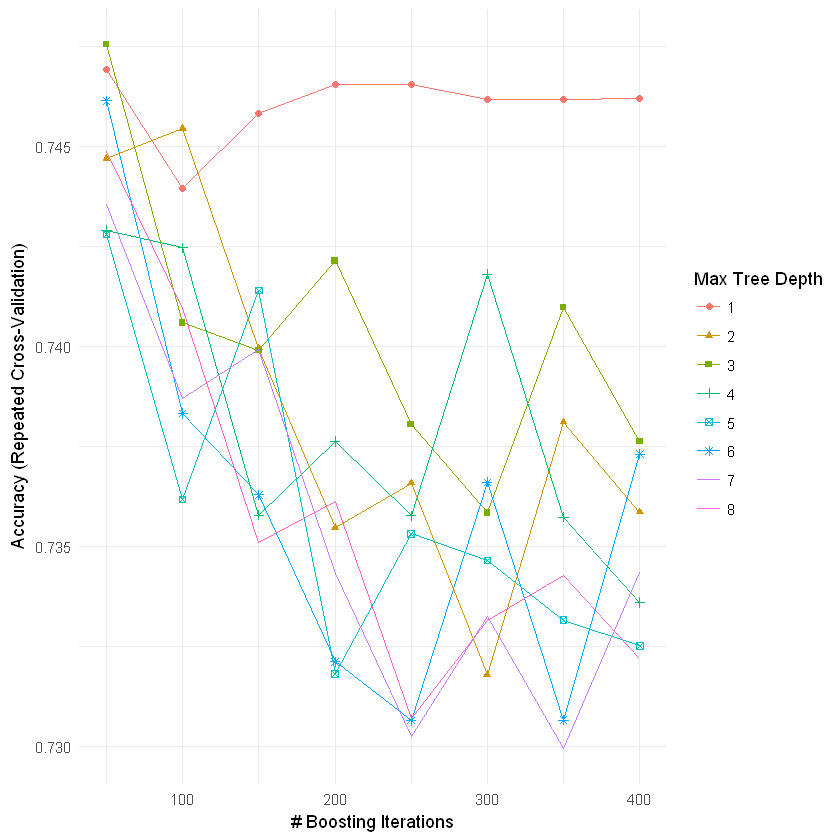

In [30]:
# Plot model training resutls
ggplot(rf_mod)

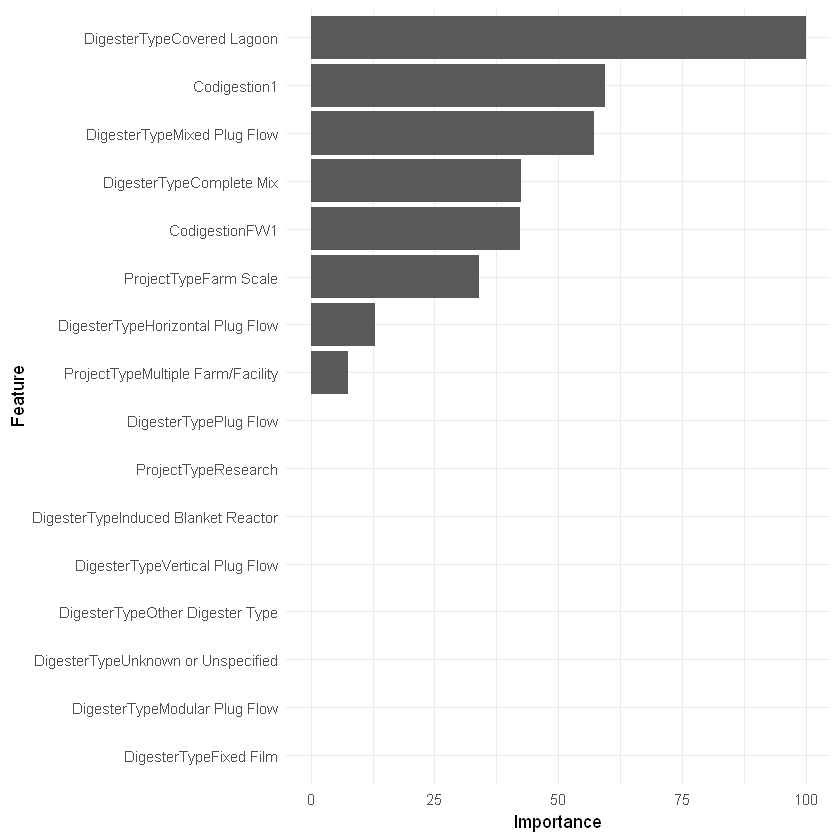

In [31]:
# Variable importance plot
ggplot(varImp(rf_mod))